In [1]:
import gym
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from sklearn.utils import shuffle

seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Helper Function : Value, GAE, Retrun, and Rewards

In [3]:
def add_value(trajectories, val_func): # Add value estimation for each trajectories
    for trajectory in trajectories:
        observes = trajectory['observes']
        values = val_func.predict(observes)
        trajectory['values'] = values

def add_gae(trajectories, gamma=0.99, lam=0.98): # generalized advantage estimation (for training stability)
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        values = trajectory['values']
        
        # temporal differences
        tds = rewards + np.append(values[1:],0) * gamma - values
        advantages = np.zeros_like(tds)
        advantage = 0
        for t in reversed(range(len(tds))):
            advantage = tds[t] + lam*gamma*advantage
            advantages[t] = advantage
        
        trajectory['advantages'] = advantages
#         trajectory['returns'] = values + advantages

def add_rets(trajectories, gamma=0.99): # compute the returns
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        
        returns = np.zeros_like(rewards)
        ret = 0
        for t in reversed(range(len(rewards))):
            ret = rewards[t] + gamma*ret
            returns[t] = ret            
        trajectory['returns'] = returns

def add_rew(trajectories, rew_func): # compute the rewards from disciriminator
    for trajectory in trajectories:
        observes = trajectory['observes']
        actions = trajectory['actions']
        observes_actions = np.concatenate([observes,actions],axis=1)
        trajectory['rewards'] = rew_func.predict(observes_actions)
    return trajectories

def add_value(trajectories, val_func): # add value using value network
    for trajectory in trajectories:
        observes = trajectory['observes']
        values = val_func.predict(observes)
        trajectory['values'] = values

def build_train_set(trajectories):
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])
    advantages = np.concatenate([t['advantages'] for t in trajectories])

    # Normalization of advantages 
    # In baselines, which is a github repo including implementation of PPO coded by OpenAI, 
    # all policy gradient methods use advantage normalization trick as belows.
    # The insight under this trick is that it tries to move policy parameter towards locally maximum point.
    # Sometimes, this trick doesnot work.
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

    return observes, actions, advantages, returns

def build_train_set_for_rew(trajectories,demonstrations):
    real_observes = np.concatenate([d['observes']  for d in demonstrations])
    real_actions = np.concatenate([d['actions'] for d in demonstrations])
    obs_act_exp = np.concatenate([real_observes,real_actions],axis=1)
    
    fake_observes = np.concatenate([t['observes'] for t in trajectories])
    fake_actions = np.concatenate([t['actions'] for t in trajectories])
    obs_act_gen = np.concatenate([fake_observes,fake_actions],axis=1)
    return obs_act_exp, obs_act_gen

def run_episode(env, policy, animate=False, evaluation=False): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        if animate:
            env.render()
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        if evaluation:
            action = policy.control(obs).reshape((1, -1)).astype(np.float32)
        else:
            action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions), np.array(rewards, dtype=np.float32), infos)

def run_policy(env, policy, episodes, evaluation=False): # collect trajectories. if 'evaluation' is ture, then only mean value of policy distribution is used without sampling.
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, policy, evaluation=evaluation)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'true_rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

# Proximal Policy Optimization Agent

In [4]:
class GaussPolicy(object):
    def __init__(self, obs_dim, act_dim, clip_range=0.2,
                 epochs=10, lr=3e-5, hdim=64, max_std=1.0,
                 seed=0):
        
        self.seed=0
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.clip_range = clip_range
        
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.max_std = max_std
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._kl_entropy()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
        # place holder for old parameters
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_std')
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        
        # MEAN FUNCTION
        self.mean = tf.layers.dense(out, self.act_dim,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                name="mean")
        # UNIT VARIANCE
        self.logits_std = tf.get_variable("logits_std",shape=(1,),initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed))
        self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std)
        
        # SAMPLE OPERATION
        self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed= self.seed)*self.std
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = tf.reduce_sum(-0.5*tf.square((y-mu)/sigma)-tf.log(sigma)- 0.5*np.log(2.*np.pi),axis=1)

        # PROBABILITY WITH OLD (PREVIOUS) PARAMETER
        old_mu_ph = self.old_mean_ph
        old_sigma_ph = self.old_std_ph
                
        self.logp_old = tf.reduce_sum(-0.5*tf.square((y-old_mu_ph)/old_sigma_ph)-tf.log(old_sigma_ph)- 0.5*np.log(2.*np.pi),axis=1)
        
    def _kl_entropy(self):

        mean, std = self.mean, self.std
        old_mean, old_std = self.old_mean_ph, self.old_std_ph
 
        log_std_old = tf.log(old_std)
        log_std_new = tf.log(std)
        frac_std_old_new = old_std/std

        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(log_std_new - log_std_old + 0.5*tf.square(frac_std_old_new) + 0.5*tf.square((mean - old_mean)/std)- 0.5,axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = tf.reduce_sum(log_std_new + 0.5 + 0.5*np.log(2*np.pi),axis=1)
        self.entropy = tf.reduce_mean(entropy)
        
    def _loss_train_op(self):
        
        # Proximal Policy Optimization CLIPPED LOSS FUNCTION
        ratio = tf.exp(self.logp - self.logp_old) 
        clipped_ratio = tf.clip_by_value(ratio,clip_value_min=1-self.clip_range,clip_value_max=1+self.clip_range) 
        self.loss = -tf.reduce_mean(tf.minimum(self.advantages_ph*ratio,self.advantages_ph*clipped_ratio))
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def sample(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action
    
    def control(self, obs): # COMPUTE MEAN
        feed_dict = {self.obs_ph: obs}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action        
    
    def update(self, observes, actions, advantages, batch_size = 128): # TRAIN POLICY
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_means_np, old_std_np = self.sess.run([self.mean, self.std],{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        for e in range(self.epochs):
            observes, actions, advantages, old_means_np, old_std_np = shuffle(observes, actions, advantages, old_means_np, old_std_np, random_state=self.seed)
            for j in range(num_batches): 
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end,:],
                     self.advantages_ph: advantages[start:end],
                     self.old_std_ph: old_std_np[start:end,:],
                     self.old_mean_ph: old_means_np[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
        feed_dict = {self.obs_ph: observes,
                 self.act_ph: actions,
                 self.advantages_ph: advantages,
                 self.old_std_ph: old_std_np,
                 self.old_mean_ph: old_means_np,
                 self.lr_ph: self.lr}             
        loss, kl, entropy = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
        return loss, kl, entropy
    
    def close_sess(self):
        self.sess.close()

# Value Function

In [5]:
class Value(object):
    def __init__(self, obs_dim, epochs=20, lr=1e-4, hdim=64, seed=0):
        self.seed = seed
    
        self.obs_dim = obs_dim
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        
        self._build_graph()
        self._init_session()
        
    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_valfunc')
            self.val_ph = tf.placeholder(tf.float32, (None,), 'val_valfunc')
            
            hid1_size = self.hdim 
            hid2_size = self.hdim 
            
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h2")
            out = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name='output')
            self.out = tf.squeeze(out)
            
            # L2 LOSS
            self.loss = tf.reduce_mean(tf.square(self.out - self.val_ph))
            
            # OPTIMIZER
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.minimize(self.loss)
            
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def fit(self, x, y, batch_size=32):
        num_batches = max(x.shape[0] // batch_size, 1)
        x_train, y_train = x, y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train, random_state=self.seed)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.val_ph: y_train[start:end]}
                self.sess.run([self.train_op], feed_dict=feed_dict)
        feed_dict = {self.obs_ph: x_train,
                     self.val_ph: y_train}
        loss, = self.sess.run([self.loss], feed_dict=feed_dict)
        return loss

    def predict(self, x): # PREDICT VALUE OF THE GIVEN STATE
        feed_dict = {self.obs_ph: x}
        y_hat = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(y_hat)

    def close_sess(self):
        self.sess.close()

# Rewards Function (Discriminator)

In [6]:
class Reward(object):
    def __init__(self, obs_dim, act_dim, epochs=10, hdim=32, lr=1e-3, entcoeff=1e-3, seed=0):
        self.replay_buffer_obs_act_gen = None
        self.seed = seed
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.hdim = hdim
        self.epochs = epochs
        self.entcoeff = entcoeff # Heuristics
        self.lr = lr
        self._build_graph()

    def _build_graph(self):
        """ Construct TensorFlow graph, including loss function, init op and train op """
        self.g = tf.Graph()
        with self.g.as_default():
            # Place Holder for 
            self.obs_act_exp_ph = tf.placeholder(tf.float32, (None, self.obs_dim + self.act_dim), 'obs_act_exp_rewfunc')
            self.obs_act_gen_ph = tf.placeholder(tf.float32, (None, self.obs_dim + self.act_dim), 'obs_act_gen_rewfunc')
            
            hid1_size = self.hdim
            hid2_size = self.hdim
            
            # Network for expert demonstrations
            out = tf.layers.dense(self.obs_act_exp_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h2")
            exp_logits = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name='output')
            self.exp_logits = tf.squeeze(exp_logits)
            
            # Network for learner's demonstrations. Use the same parameter which is defined above
            out = tf.layers.dense(self.obs_act_gen_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h1", reuse=True) # Reuse=Ture -> use the same parameter
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name="h2", reuse=True) # Reuse=Ture -> use the same parameter
            gen_logits = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=0.01,seed=self.seed), name='output', reuse=True) # Reuse=Ture -> use the same parameter
            self.gen_logits = tf.squeeze(gen_logits)

            # Check accuracy
            self.generator_acc = tf.reduce_mean(tf.to_float(tf.nn.sigmoid(gen_logits) > 0.5))
            self.expert_acc = tf.reduce_mean(tf.to_float(tf.nn.sigmoid(exp_logits) < 0.5))
            
            # Loss for classification
            generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=gen_logits, labels=tf.ones_like(gen_logits))
            generator_loss = tf.reduce_mean(generator_loss)
            expert_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=exp_logits, labels=tf.zeros_like(exp_logits))
            expert_loss = tf.reduce_mean(expert_loss)
            
            # Entropy regularization
            logits = tf.concat([gen_logits, exp_logits], 0)
            prob = tf.nn.sigmoid(logits)
            entropy = tf.reduce_mean(-prob*tf.log(prob)-(1-prob)*tf.log(1-prob)) 
            entropy_loss = -self.entcoeff*entropy
            
            # Total loss
            self.loss = generator_loss + expert_loss + entropy_loss
            
            # Build Reward for policy
            self.reward = -tf.log(tf.nn.sigmoid(gen_logits))
            
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.train_op = optimizer.minimize(self.loss)
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def fit(self, obs_act_exp, obs_act_gen, batch_size=128):
        data_size = min(obs_act_exp.shape[0],obs_act_gen.shape[0])
        num_batches = max(data_size // batch_size, 1)
        batch_size = data_size // num_batches
        
        obs_act_exp_train = obs_act_exp
        if self.replay_buffer_obs_act_gen is None:
            obs_act_gen_train = obs_act_gen
        else:
            obs_act_gen_train = np.concatenate([obs_act_gen, self.replay_buffer_obs_act_gen])
        self.replay_buffer_obs_act_gen = obs_act_gen
        
        for e in range(self.epochs):
            obs_act_exp_train = shuffle(obs_act_exp_train, random_state=self.seed)
            obs_act_gen_train = shuffle(obs_act_gen_train, random_state=self.seed)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_act_gen_ph:obs_act_gen_train[start:end,:], self.obs_act_exp_ph:obs_act_exp_train[start:end,:]}
                self.sess.run(self.train_op, feed_dict=feed_dict)
        feed_dict = {self.obs_act_gen_ph:obs_act_gen_train, self.obs_act_exp_ph:obs_act_exp_train}
        loss, gen_acc, exp_acc = self.sess.run([self.loss,self.generator_acc,self.expert_acc], feed_dict=feed_dict)
        return loss, gen_acc, exp_acc
    
    def predict(self, x): # Predict the rewards
        feed_dict = {self.obs_act_gen_ph: x}
        rew_hat = self.sess.run(self.reward, feed_dict=feed_dict)
        return np.squeeze(rew_hat)
        
    def close_sess(self):
        self.sess.close()

# Define Environment and Load Expert's Demonstrations

In [7]:
envname = 'MountainCarContinuous-v0'

# Load demonstrations
demo_file = open('./'+envname+'_expert_demo.pkl', 'rb')
n_demos = 10
demonstrations, = pickle.load(demo_file)[:n_demos]
demonstrations = shuffle(demonstrations,random_state=seed)

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
print('{} demos are loaded'.format(n_demos))
print('Expert\'s Performance {:.3f}'.format(exp_ret))

demo_observes = []
demo_actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        demo_observes.append(obs)
    for act in demonstration['actions']:
        demo_actions.append(act)
demo_observes=np.asarray(demo_observes)
demo_actions=np.asarray(demo_actions)

10 demos are loaded
Expert's Performance 92.459


# Run Generative Adversarial Imitation Learning (GAIL)

In [8]:
env = gym.make(envname)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Define three networks
policy = GaussPolicy(obs_dim, act_dim, epochs=10, hdim=64, lr=3e-4, clip_range=0.2, seed=seed)
val_func = Value(obs_dim, epochs=20, hdim=32, lr=1e-3, seed=seed)
rew_func = Reward(obs_dim, act_dim, epochs=10, hdim=32, lr=1e-4, seed=seed)

nupdates = 100
batch_size = 128
n_episodes = 10
train_rewards = True
for update in range(nupdates+1):

    # Generate data
    trajectories = run_policy(env, policy, episodes=n_episodes)

    # Build data set for training rewards function
    obs_act_exp, obs_act_gen = build_train_set_for_rew(trajectories,demonstrations) 
    if train_rewards:
        # Train rewards function
        rew_loss, gen_acc, exp_acc = rew_func.fit(obs_act_exp, obs_act_gen, batch_size=batch_size)
        if gen_acc > 0.8 and exp_acc > 0.8:
            train_rewards = False
    
    add_rew(trajectories,rew_func) # add estimated rewards to episodes
    add_value(trajectories, val_func)  # add estimated values to episodes
    add_rets(trajectories)  # calculated discounted sum of Rs
    add_gae(trajectories)  # calculate advantage
    # Build data set for training policy and value function
    observes, actions, advantages, returns = build_train_set(trajectories)

    # Train policy and value
    pol_loss, pol_kl, pol_entropy = policy.update(observes, actions, advantages, batch_size=batch_size)  # update policy
    vf_loss = val_func.fit(observes, returns, batch_size=batch_size)  # update value function

    mean_ret = np.mean([np.sum(t['true_rewards']) for t in trajectories])
    train_ret = np.mean([np.sum(t['rewards']) for t in trajectories])
    if (update%10) == 0:
        print('[{}/{}] True Mean Ret : {:.3f}, Train Mean Ret : {:.3f}, Reward Loss : {:.3f}, Reward Acc : [{:.3f},{:.3f}], Value Loss : {:.3f}, Policy loss : {:.5f}, Policy KL : {:.5f}, Policy Entropy : {:.3f} ***'.
              format(update, nupdates, mean_ret, train_ret, rew_loss, gen_acc, exp_acc, vf_loss, pol_loss, pol_kl, pol_entropy))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/100] True Mean Ret : -25.073, Train Mean Ret : 592.401, Reward Loss : 1.123, Reward Acc : [0.685,0.835], Value Loss : 253.009, Policy loss : -0.01440, Policy KL : 0.00889, Policy Entropy : 0.721 ***
[10/100] True Mean Ret : -34.129, Train Mean Ret : 593.563, Reward Loss : 1.062, Reward Acc : [0.620,0.879], Value Loss : 146.734, Policy loss : -0.00303, Policy KL : 0.00261, Policy Entropy : 0.530 ***
[20/100] True Mean Ret : -26.540, Train Mean Ret : 421.743, Reward Loss : 0.704, Reward Acc : [0.729,1.000], Value Loss : 72.404, Policy loss : 0.00173, Policy KL : 0.01355, Policy Entropy : -0.001 ***
[30/100] True Mean Ret : -18.875, Train Mean Ret : 328.191, Reward Loss : 0.526, Reward Acc : [0.798,1.000], Value Loss : 61.906, Policy loss : -0.00128, Policy KL : 0.00861, Policy Entropy : -0.

# Visualization

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 95.03



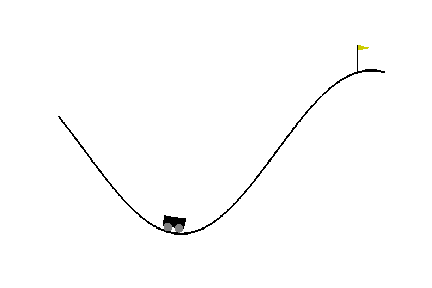
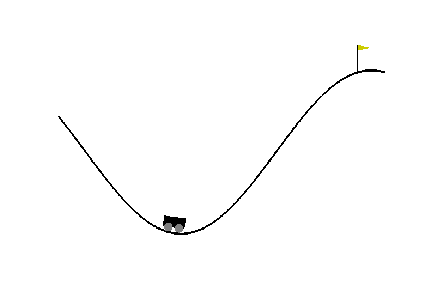
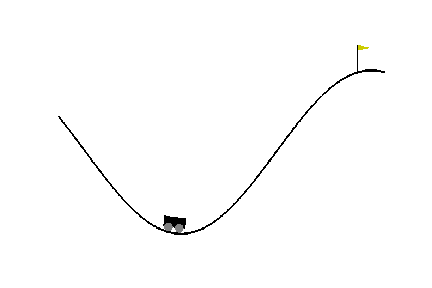
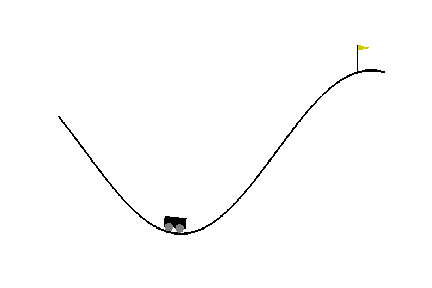
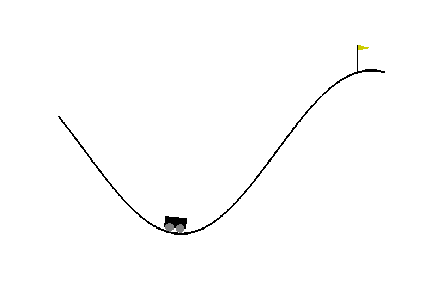
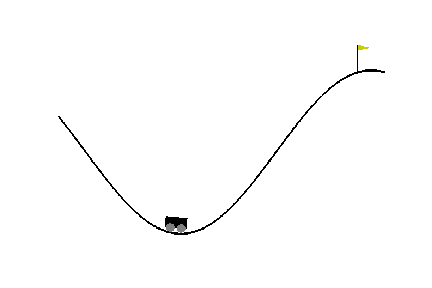
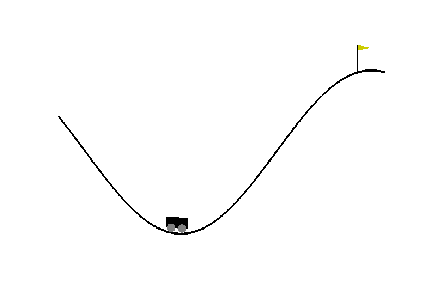
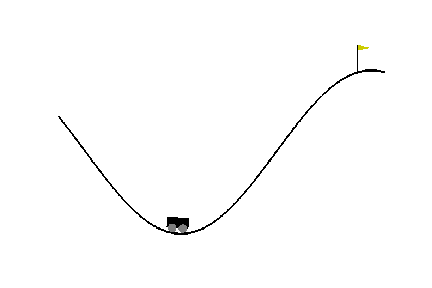
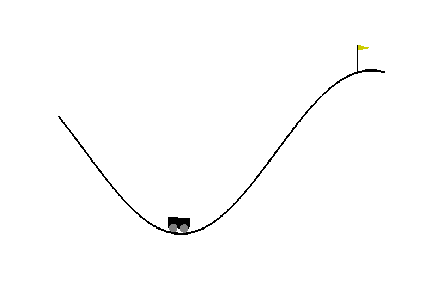
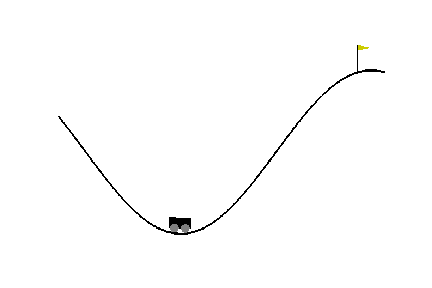
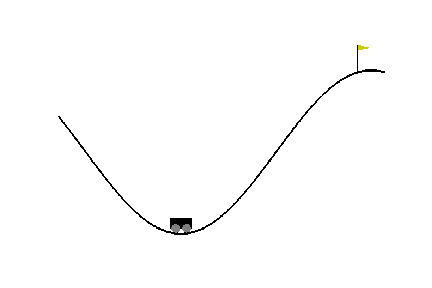
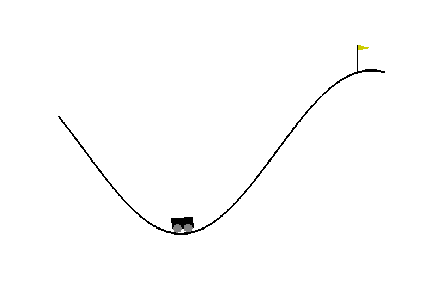
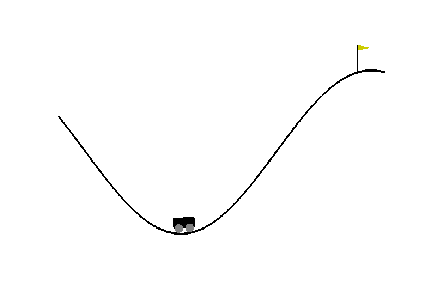
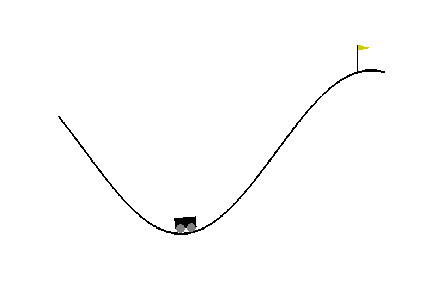
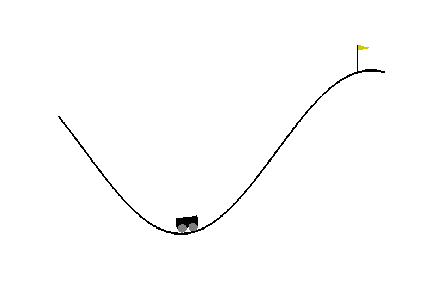
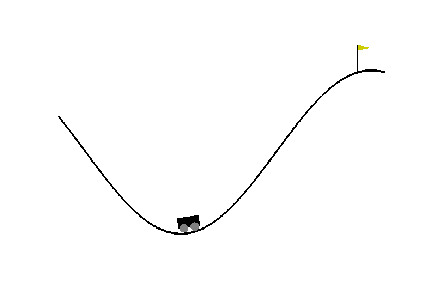
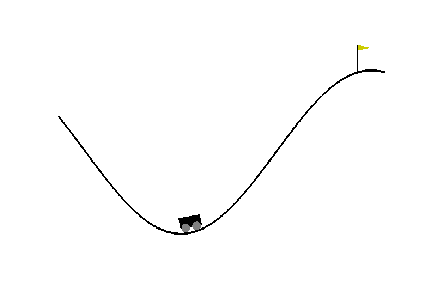
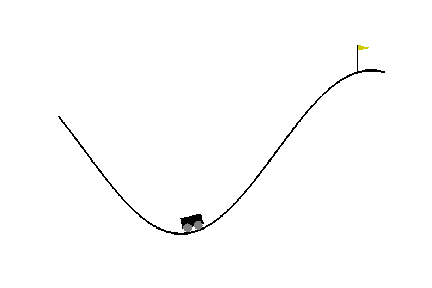
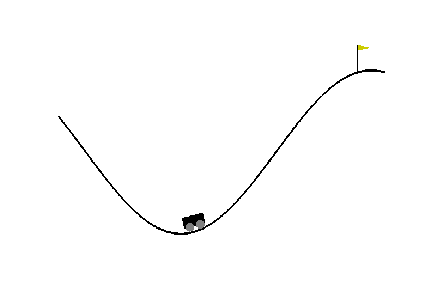
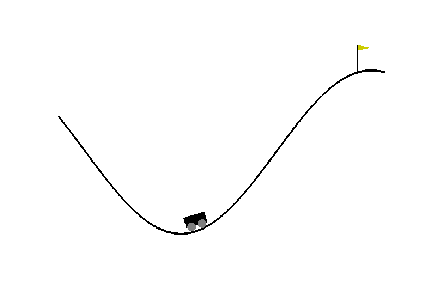
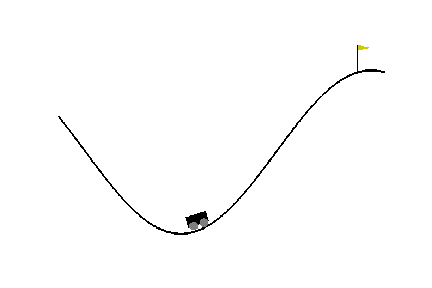
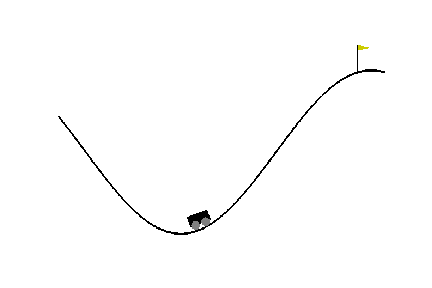
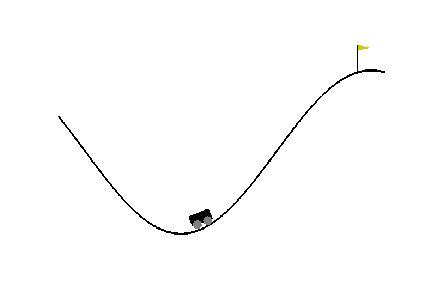
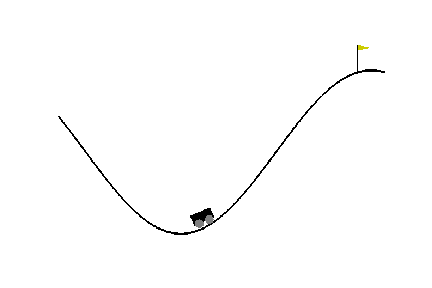
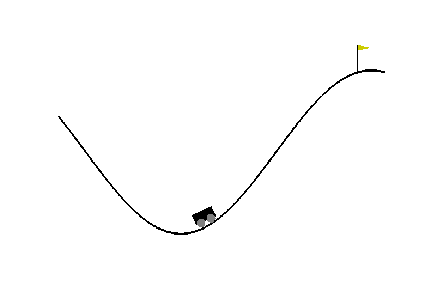
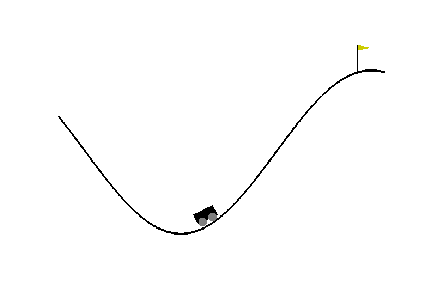
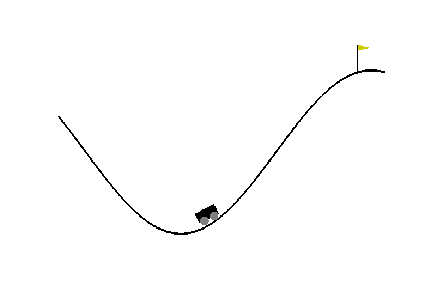
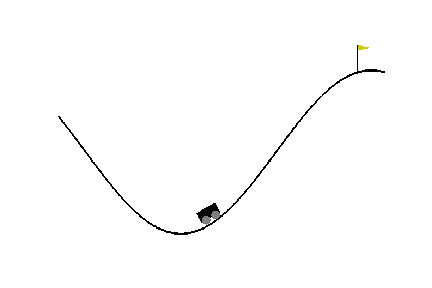
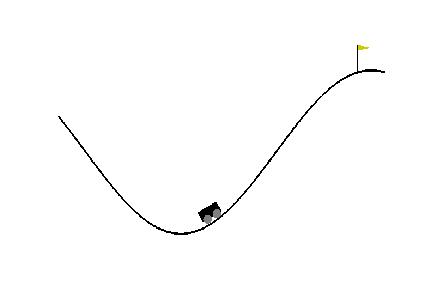
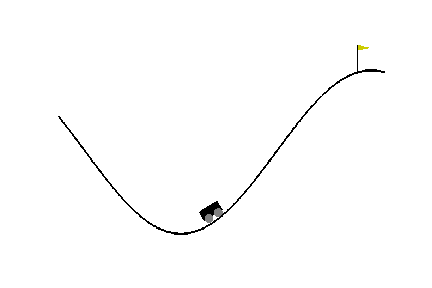
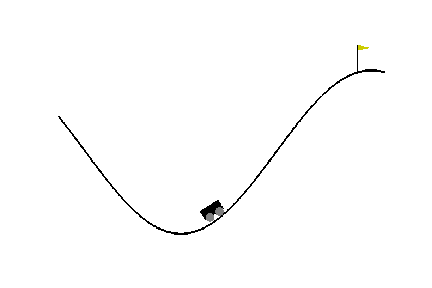
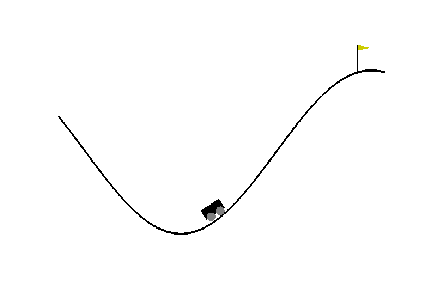
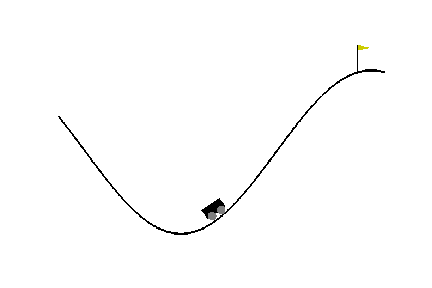
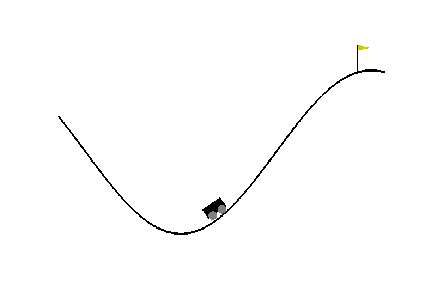
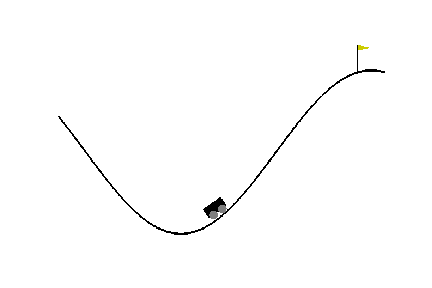
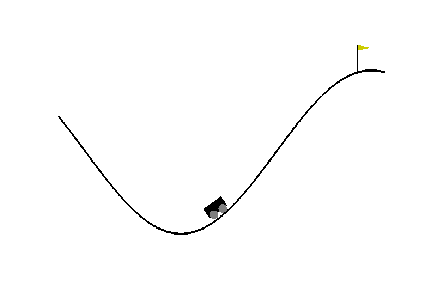
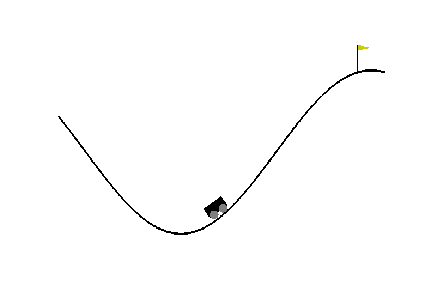
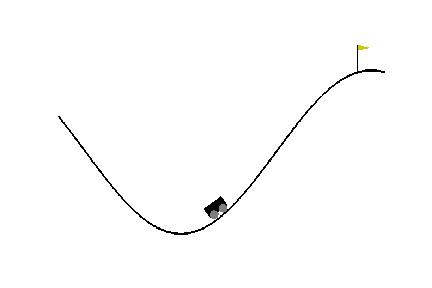
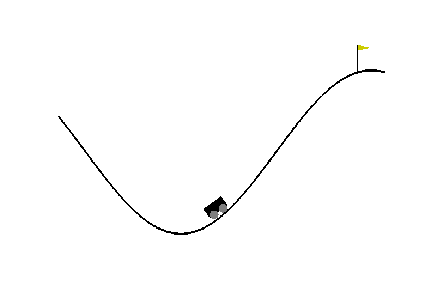
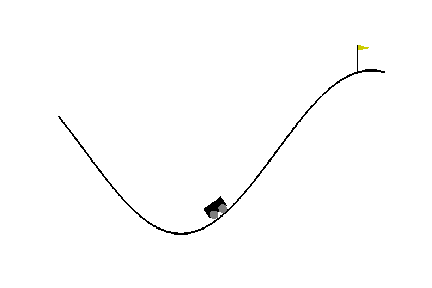
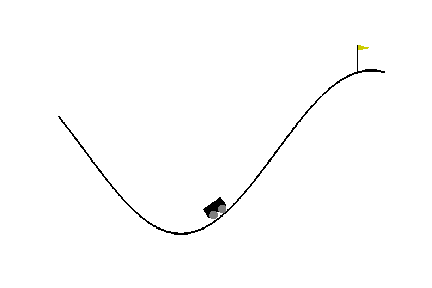
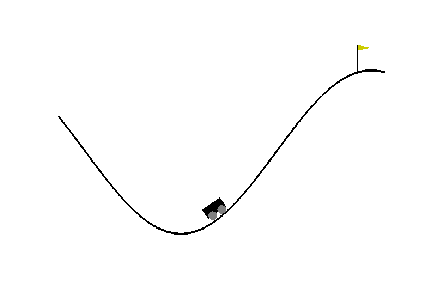
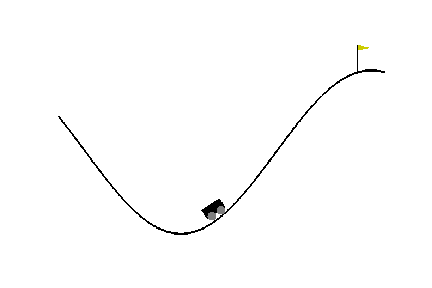
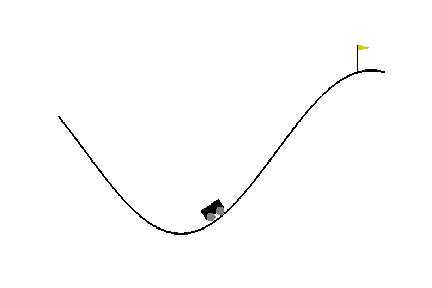
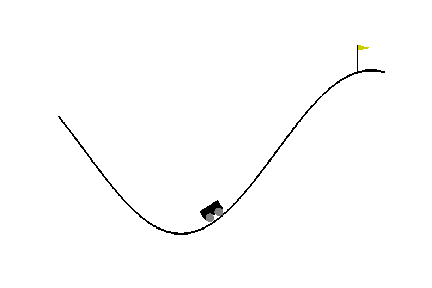
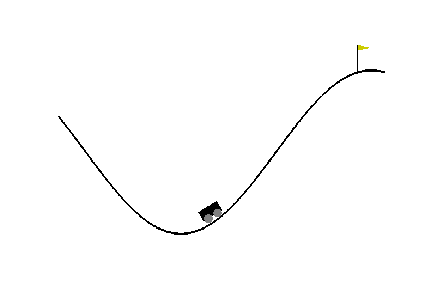
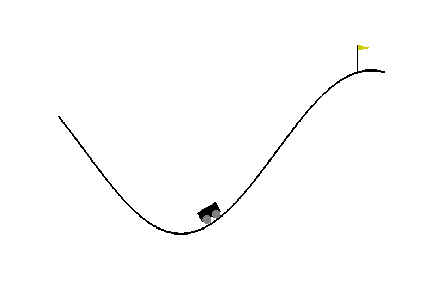
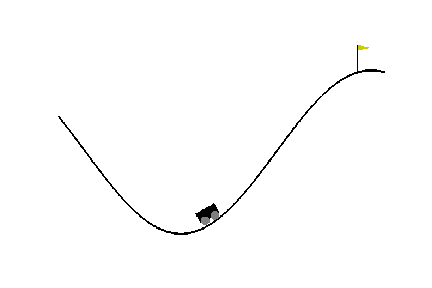
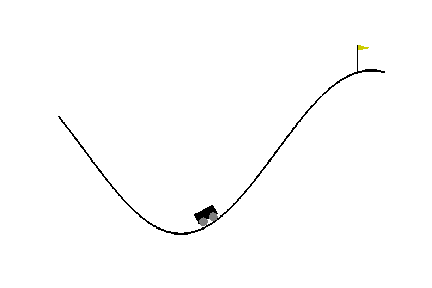
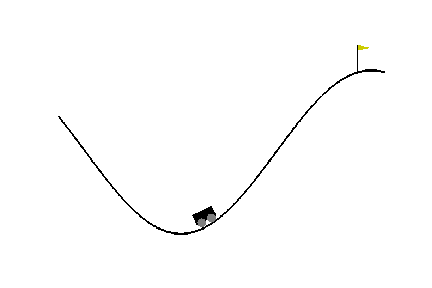
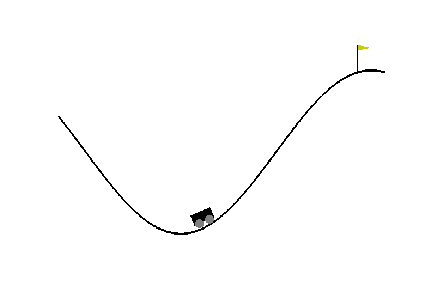
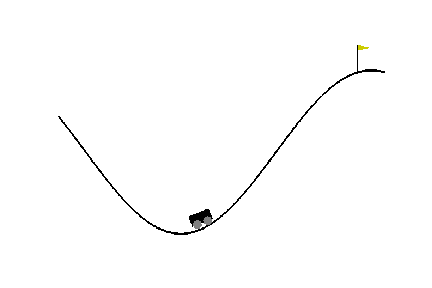
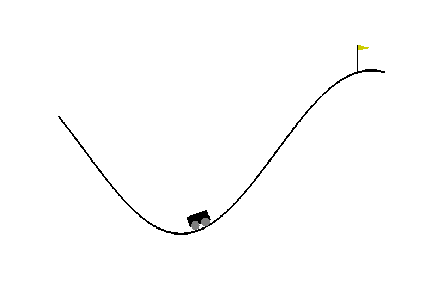
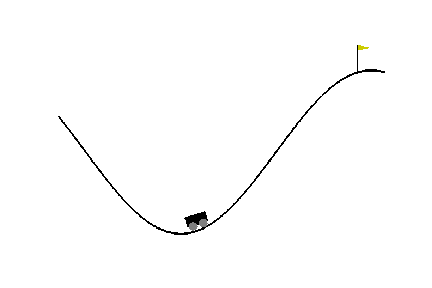
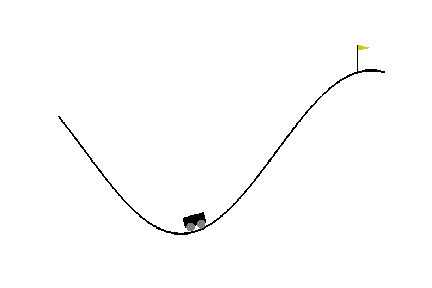
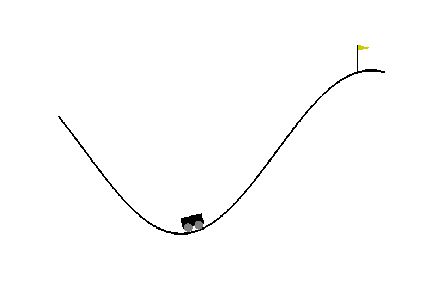
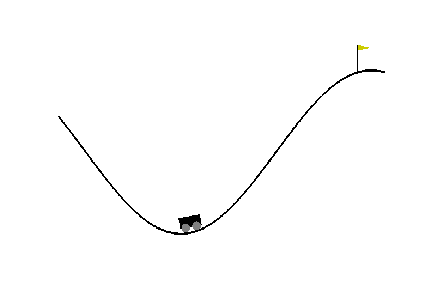
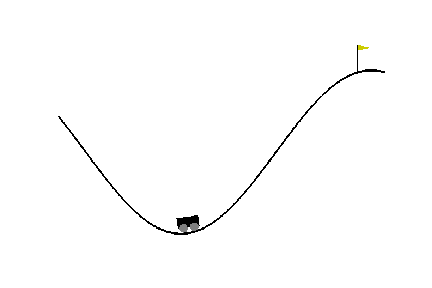
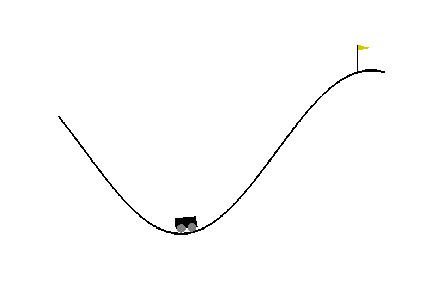
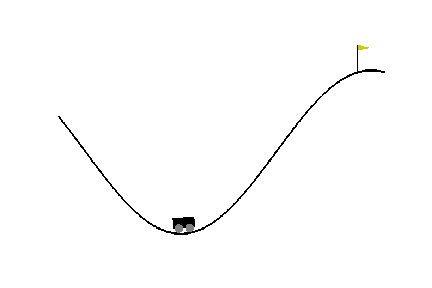
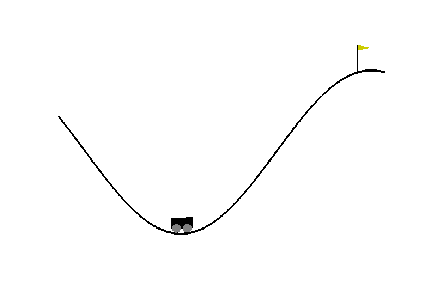
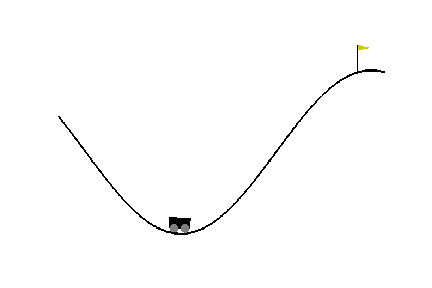
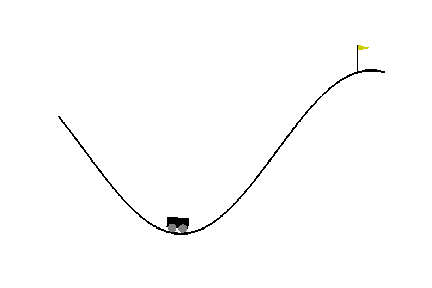
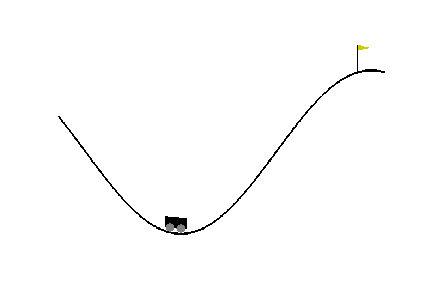
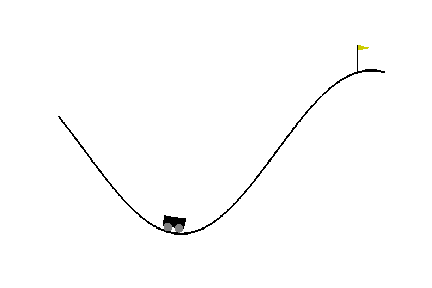
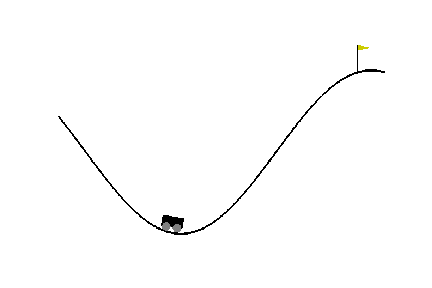
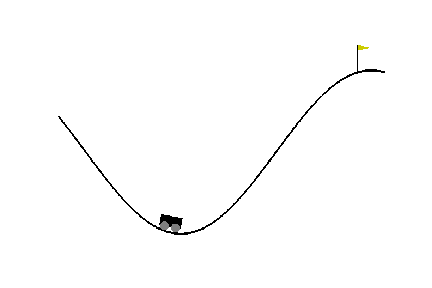
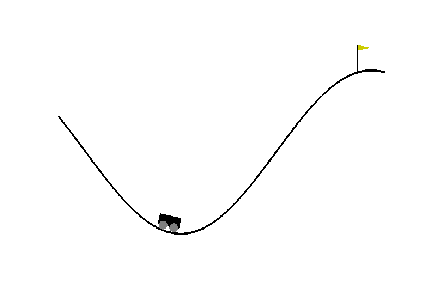
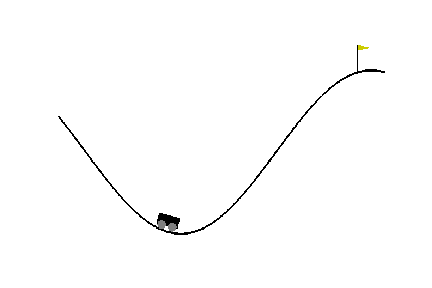
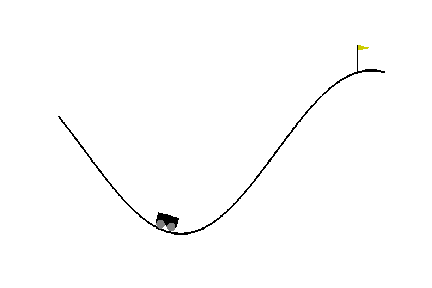
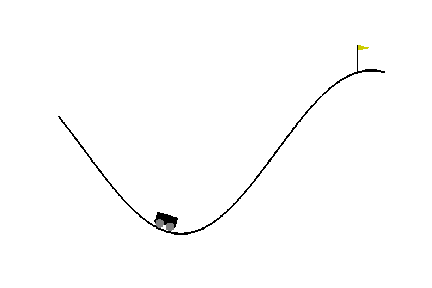
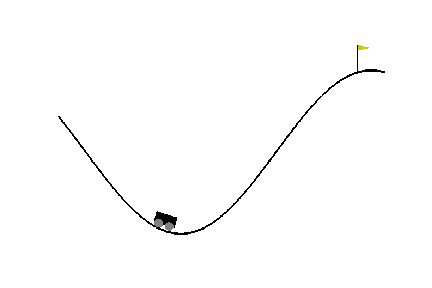
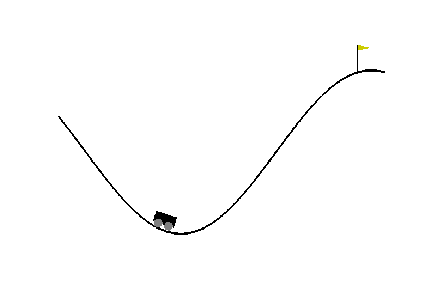
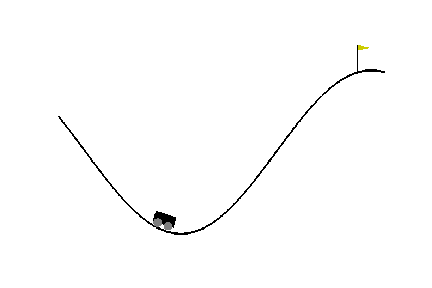
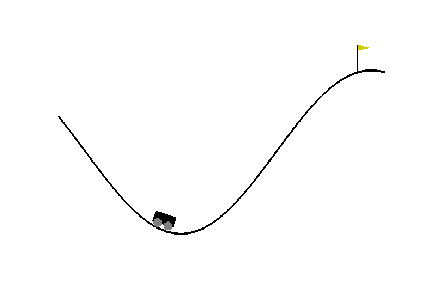
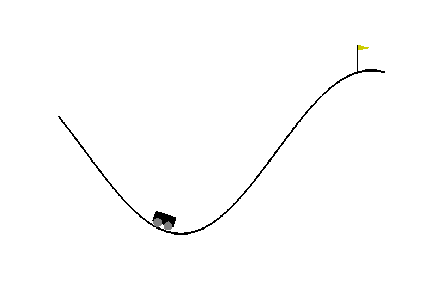
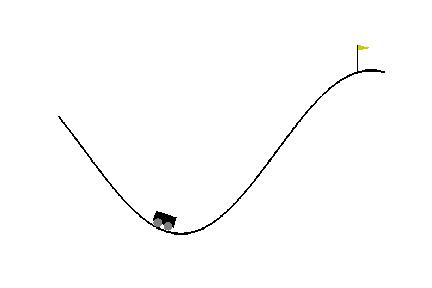
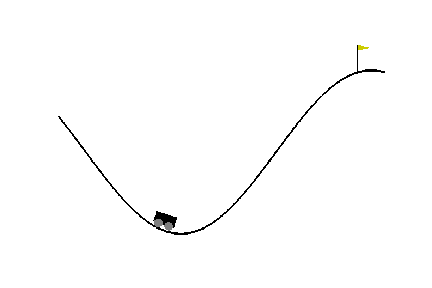
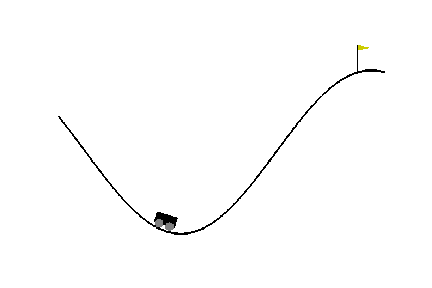
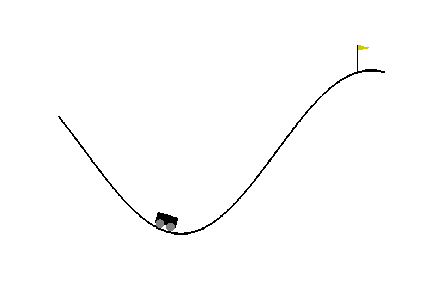
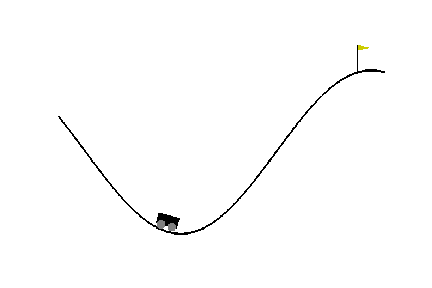
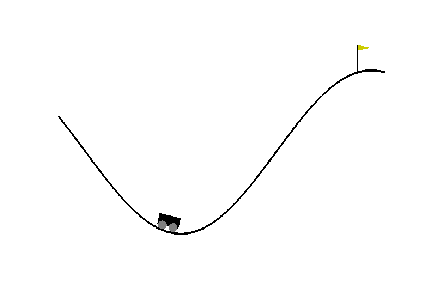
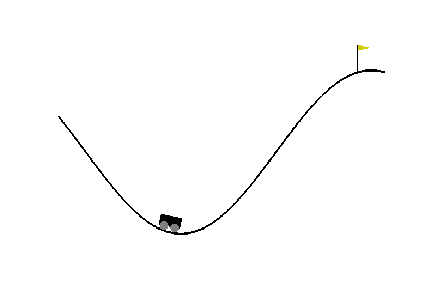
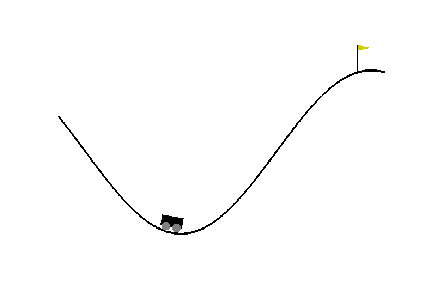
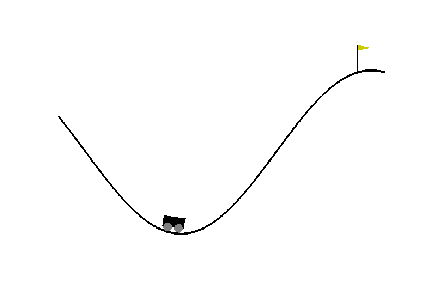
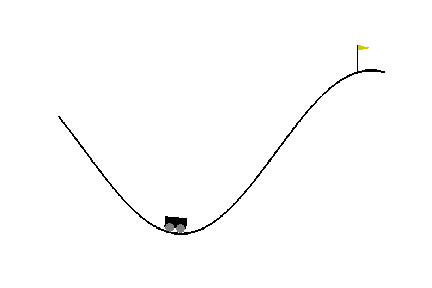
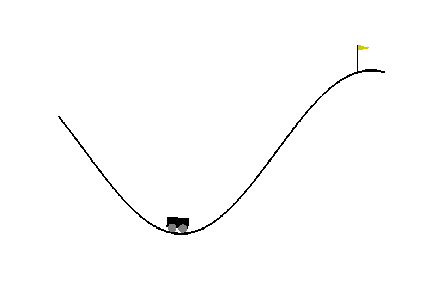
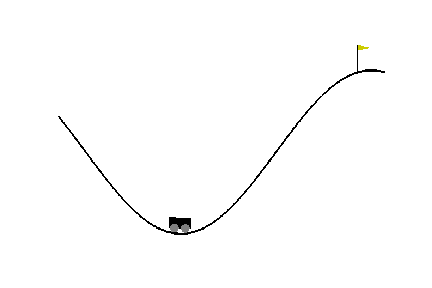
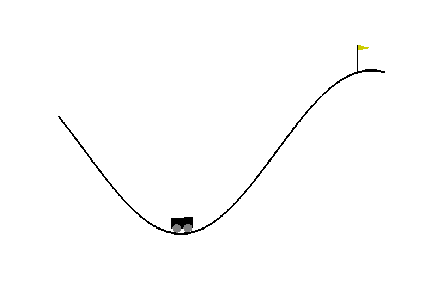
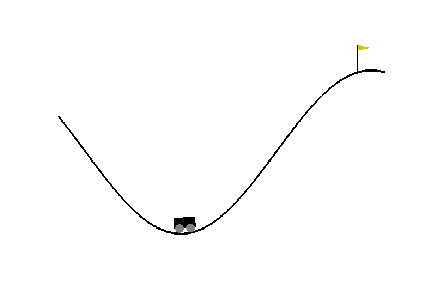
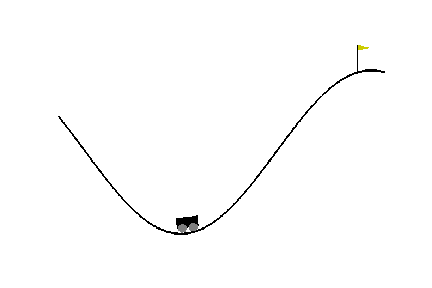
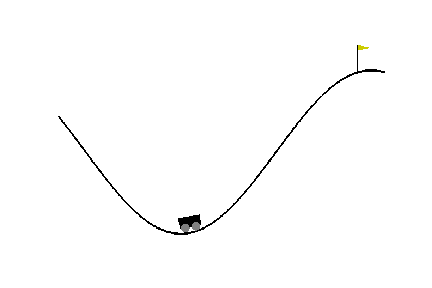
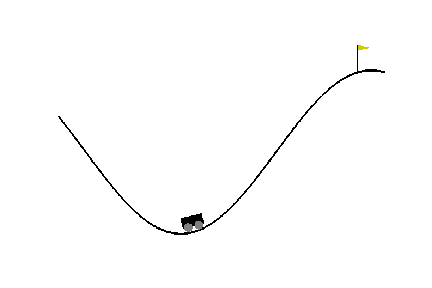
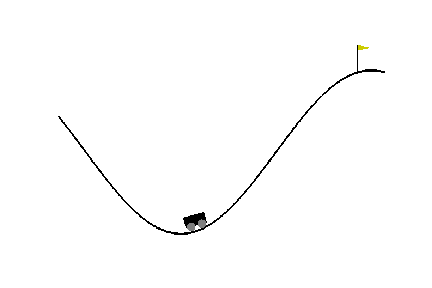
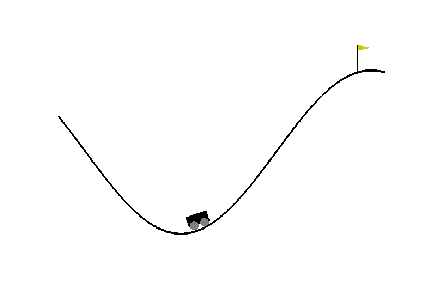
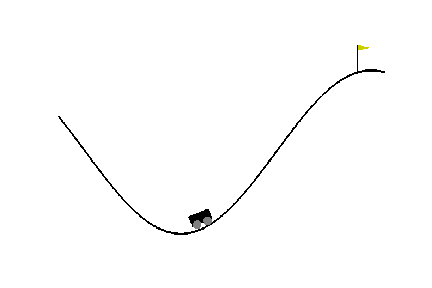
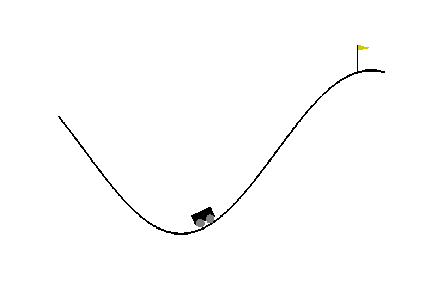
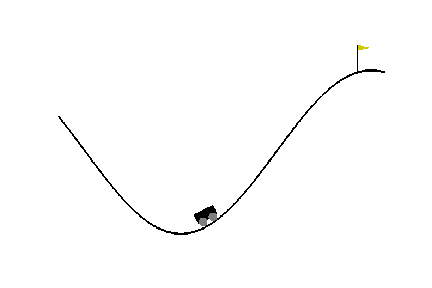
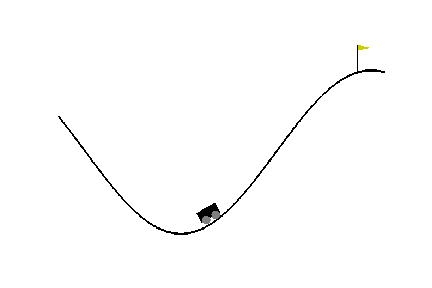
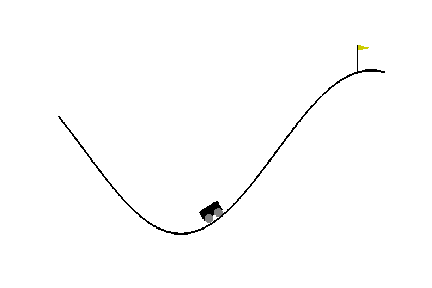
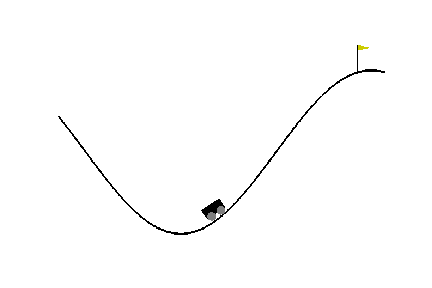
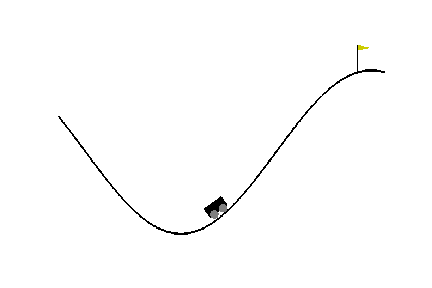
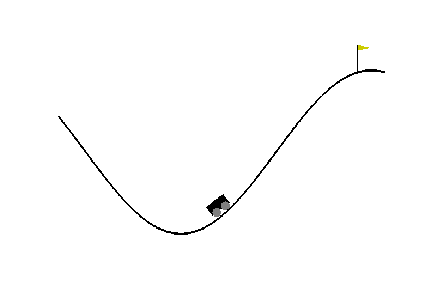
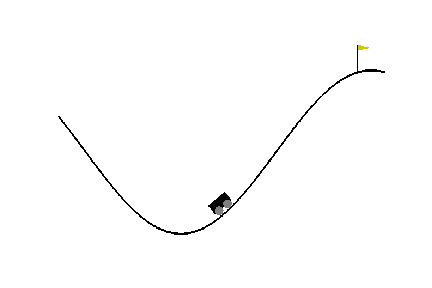
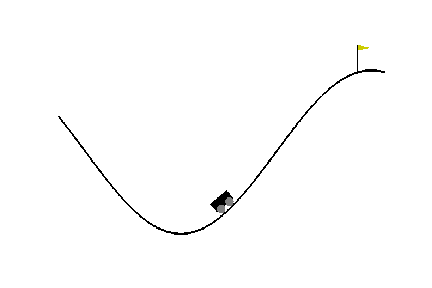
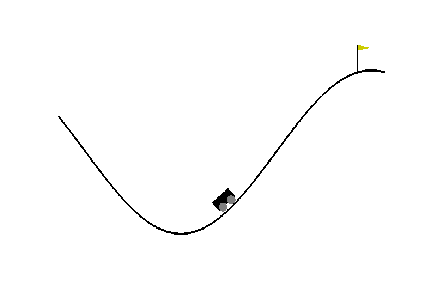
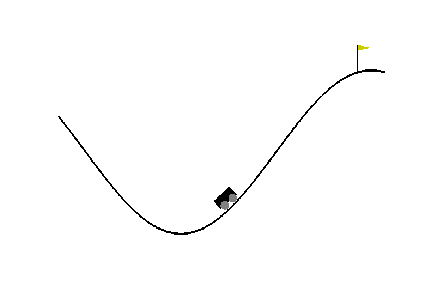
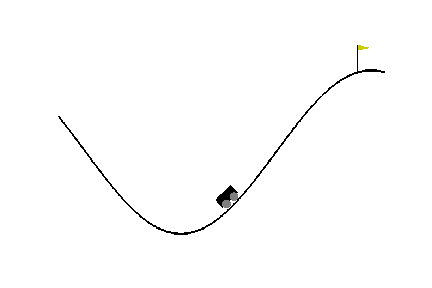
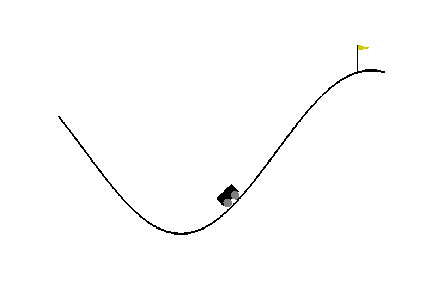
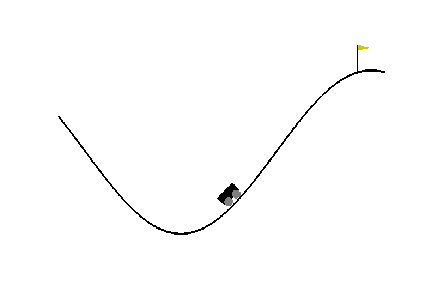
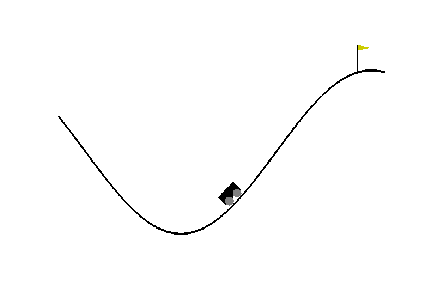
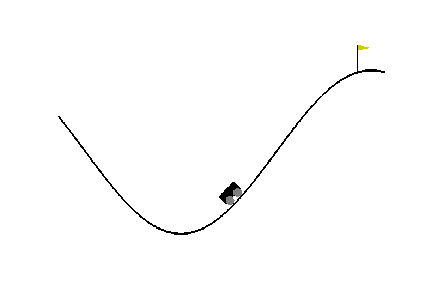
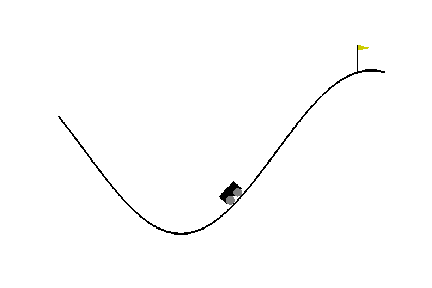
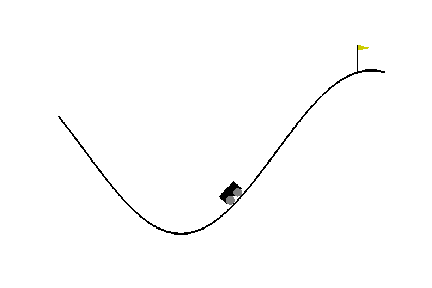
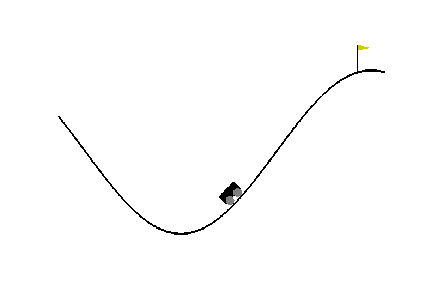
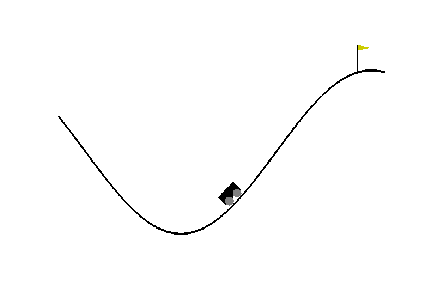
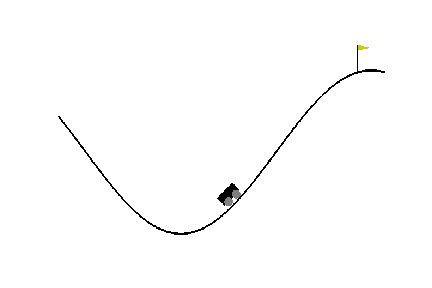
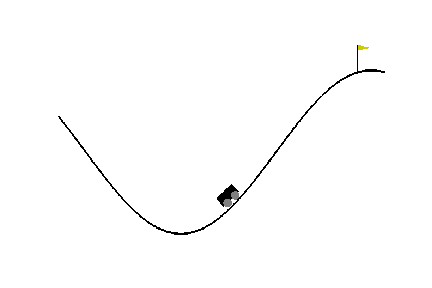
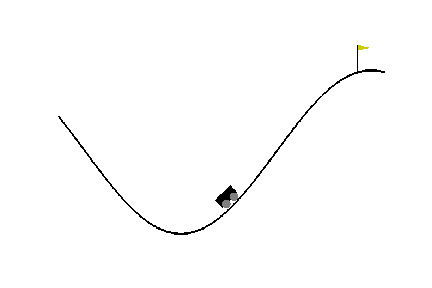
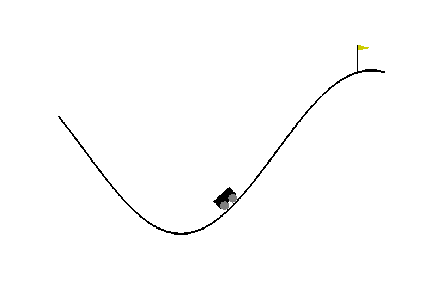
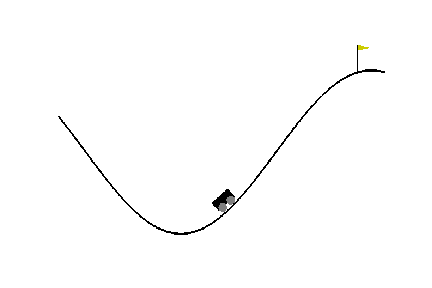
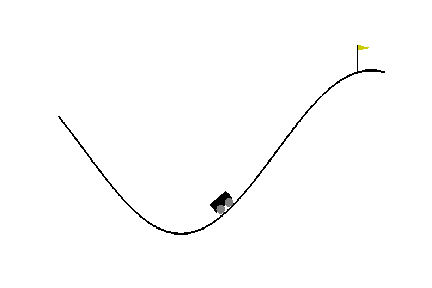
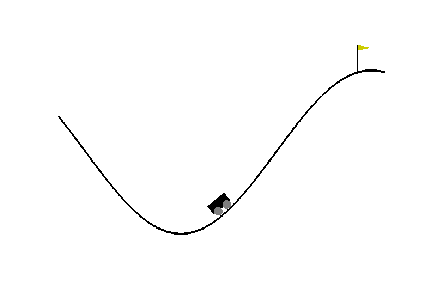
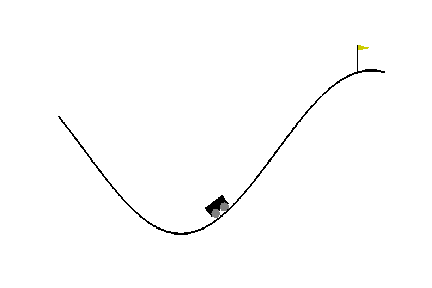
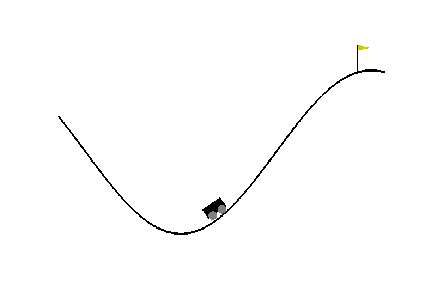
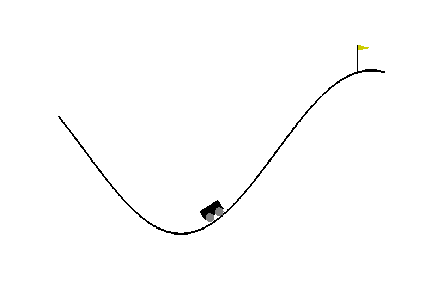
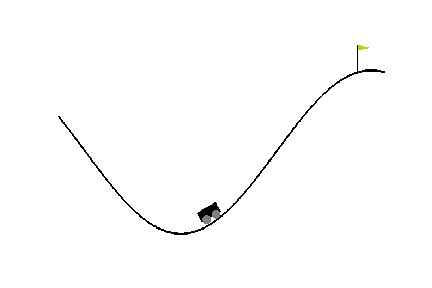
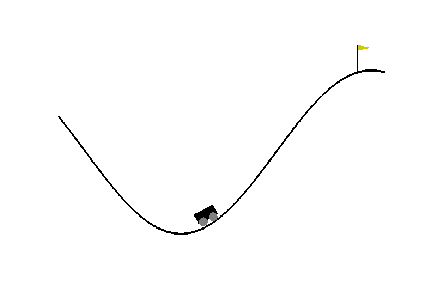
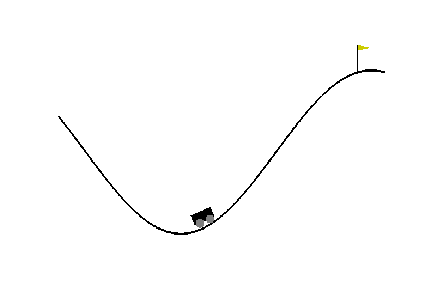
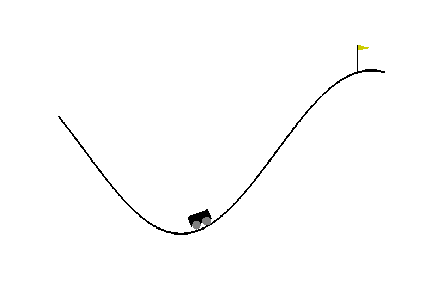
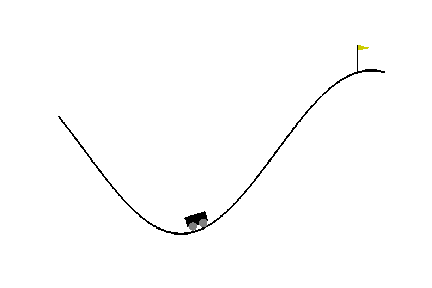
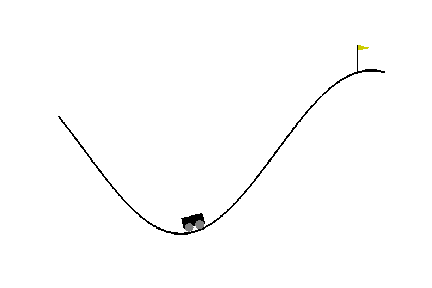
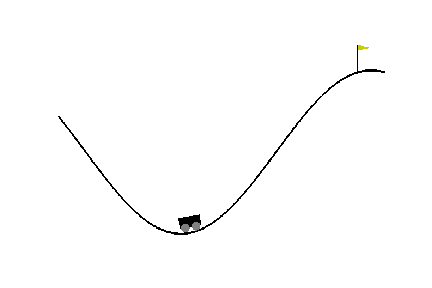
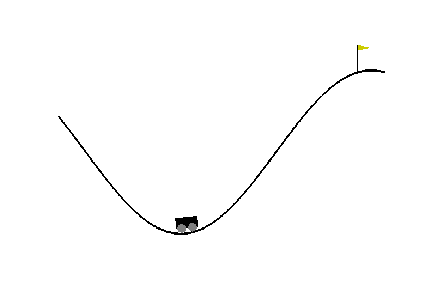
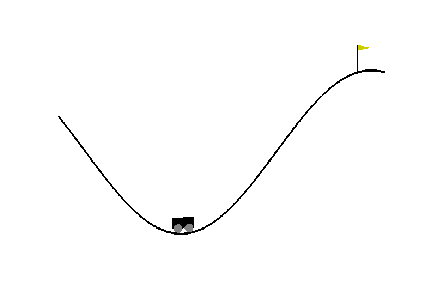
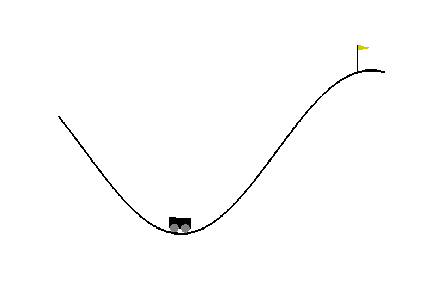
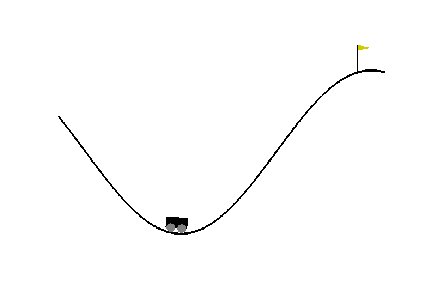
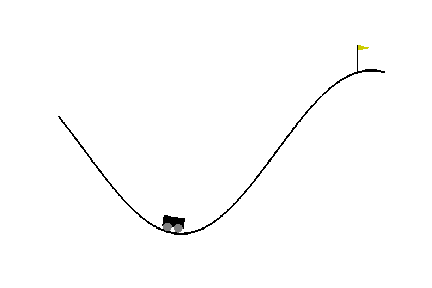
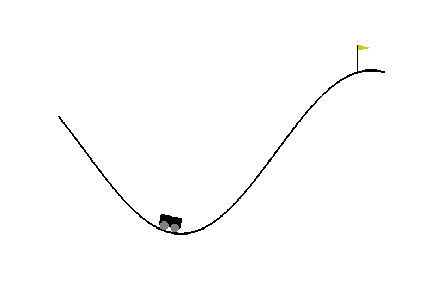
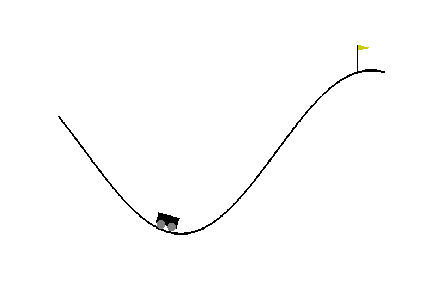
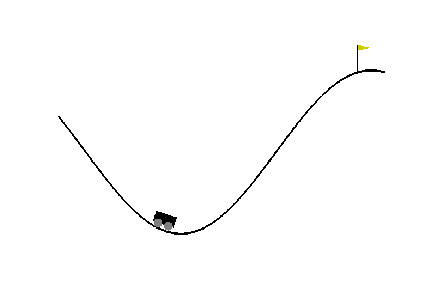
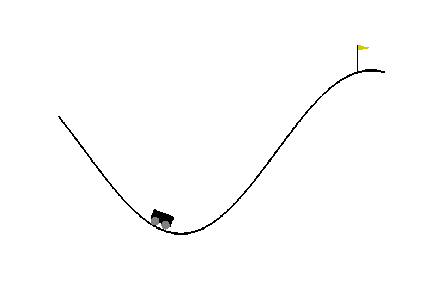
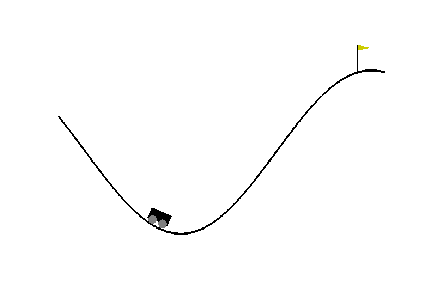
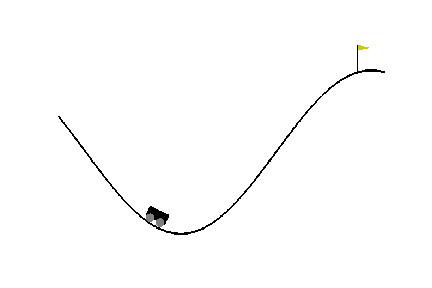
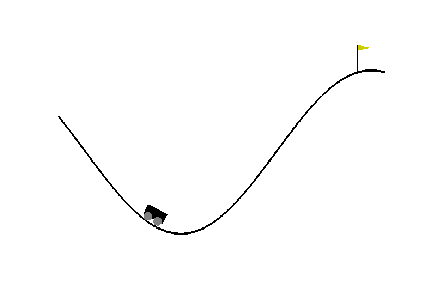
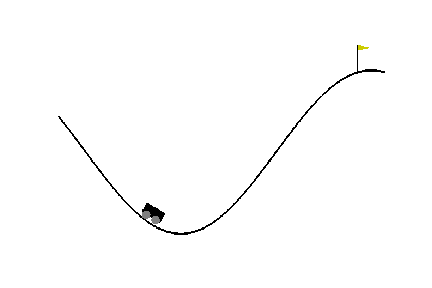
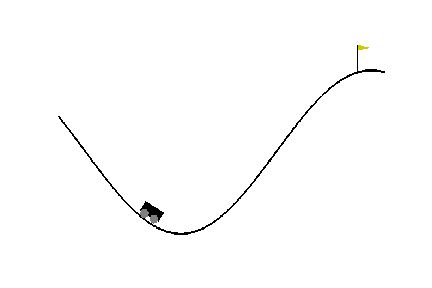
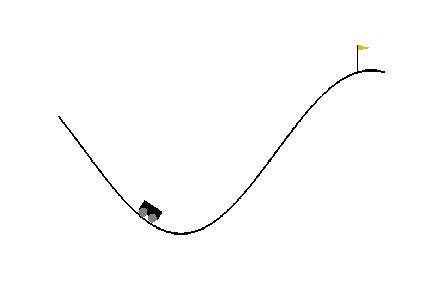
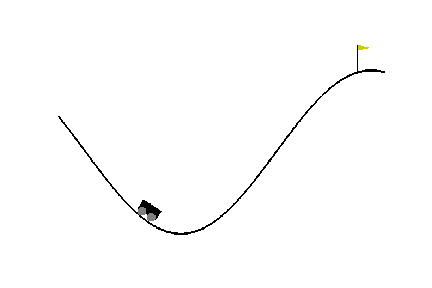
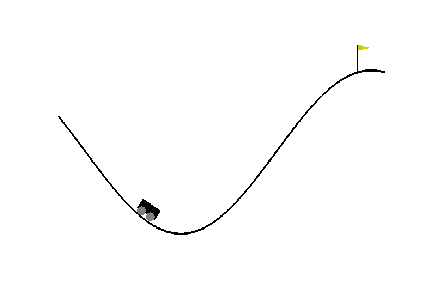
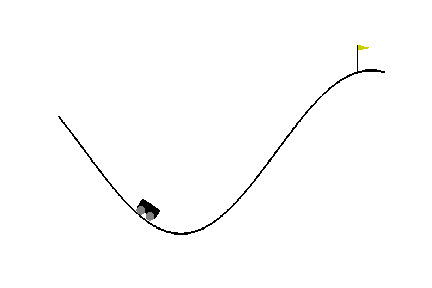
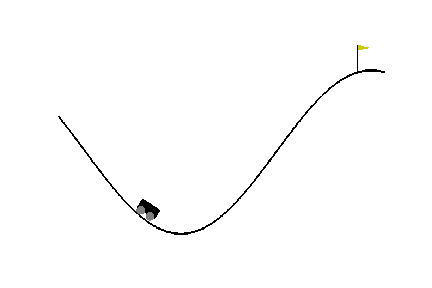
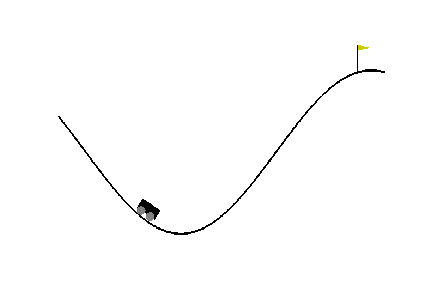
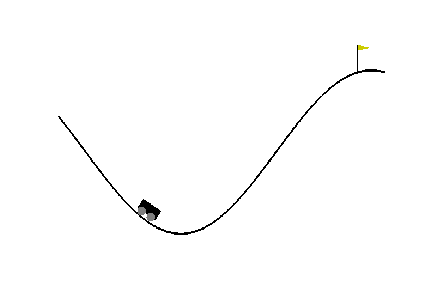
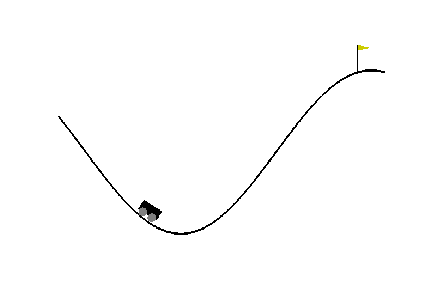
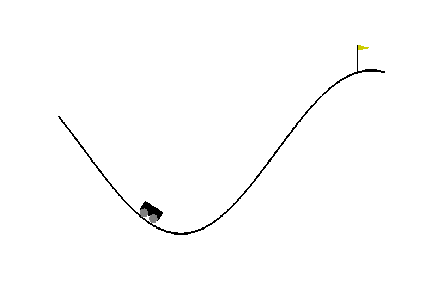
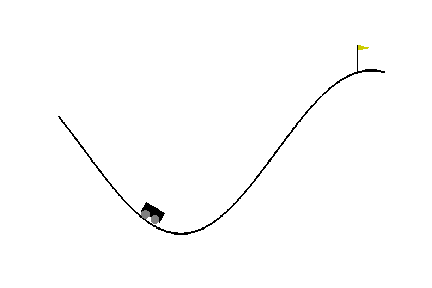
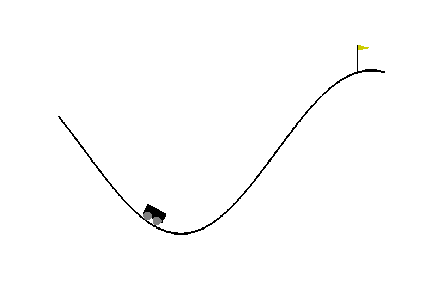
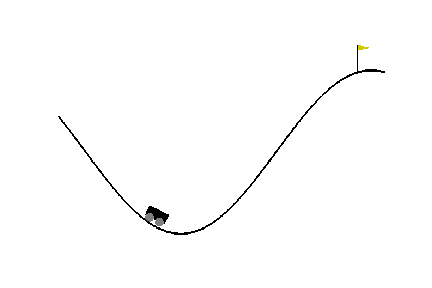
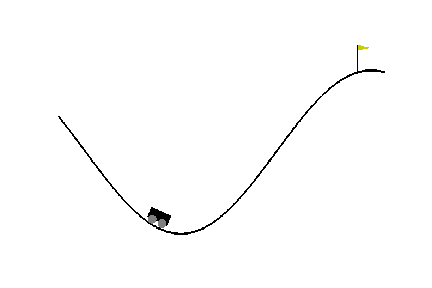
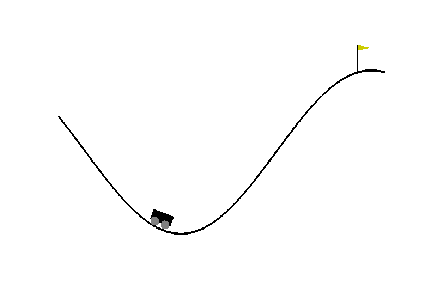
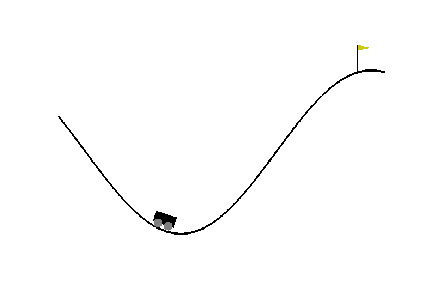
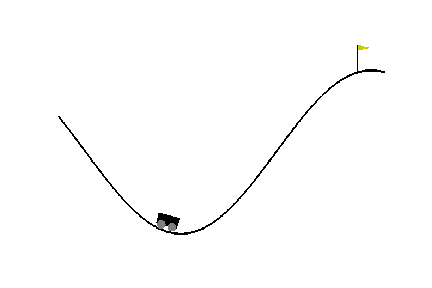
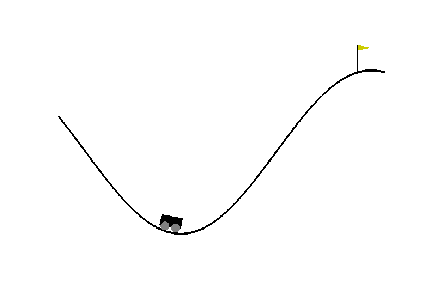
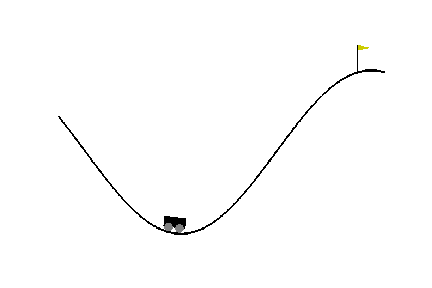
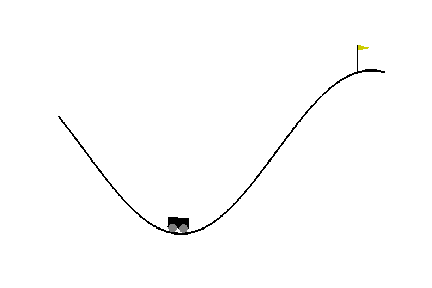
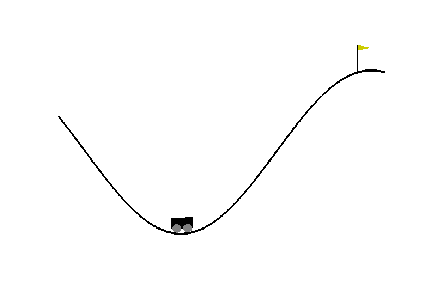
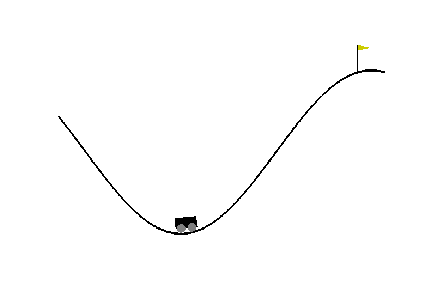
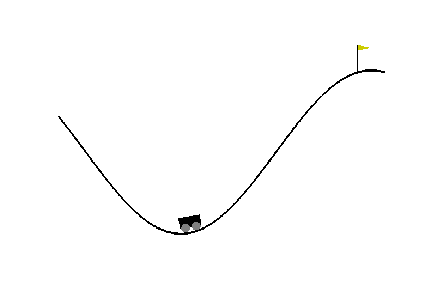
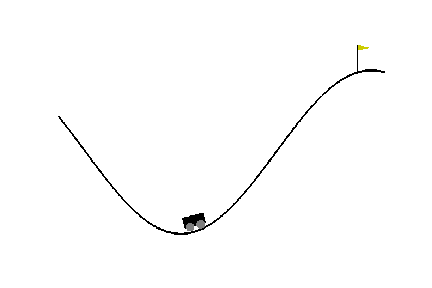
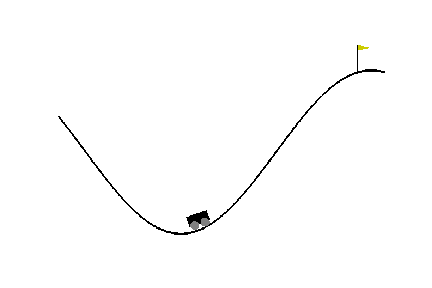
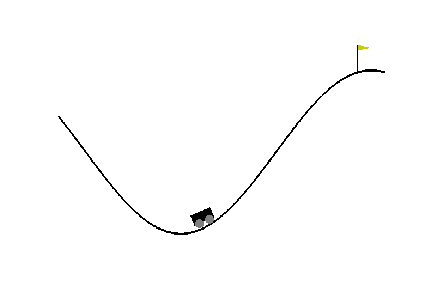
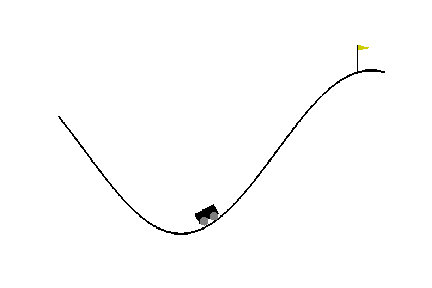
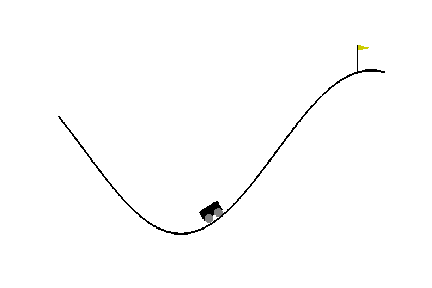
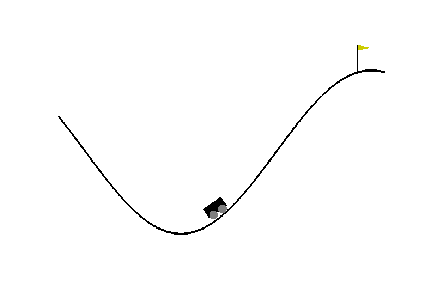
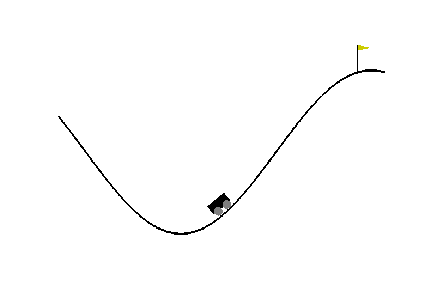
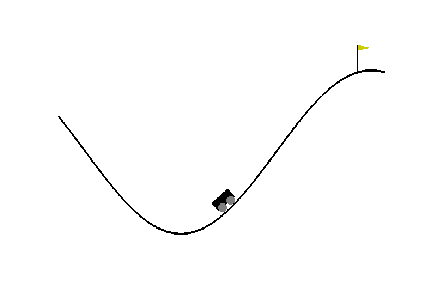
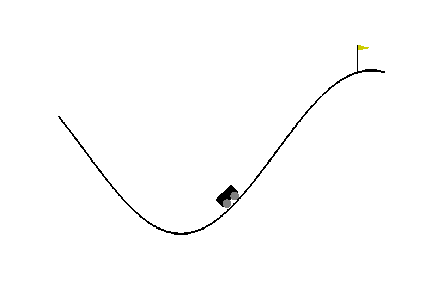
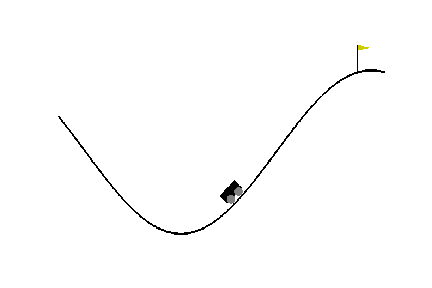
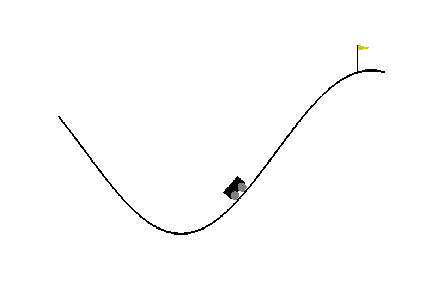
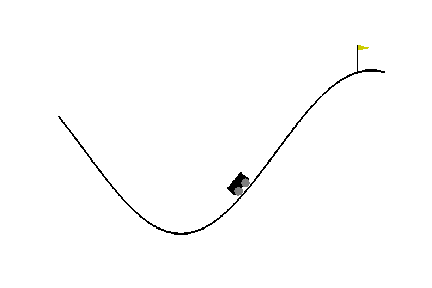
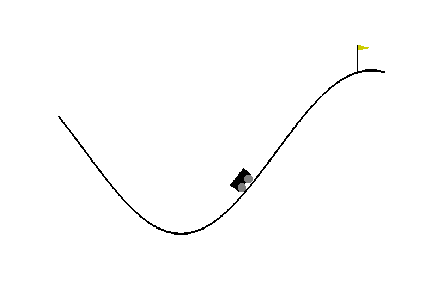
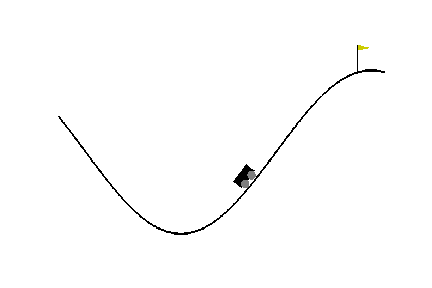
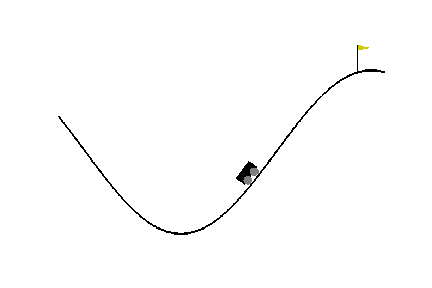
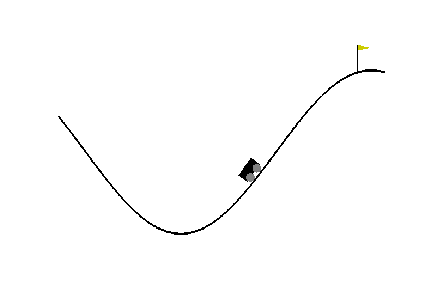
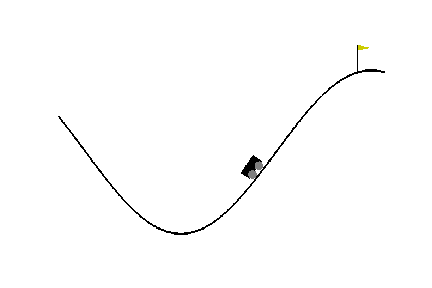
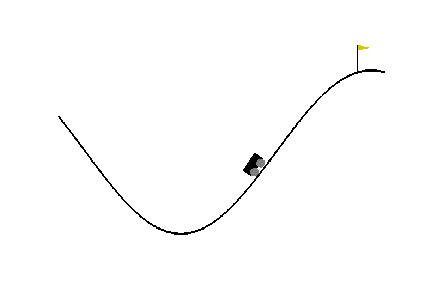
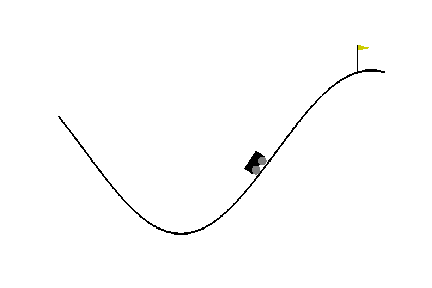
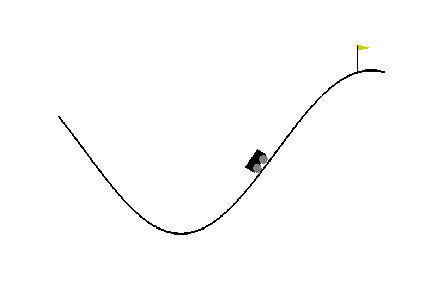
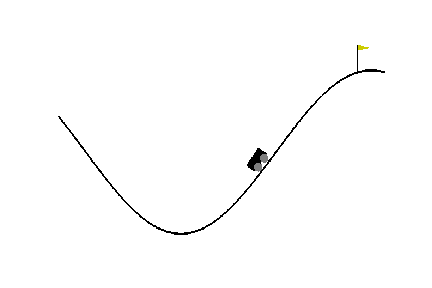
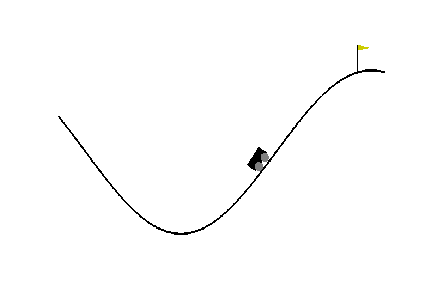
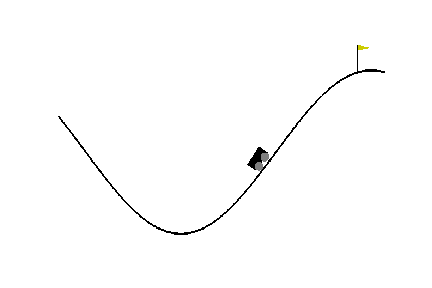
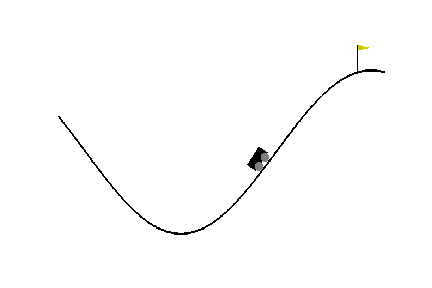
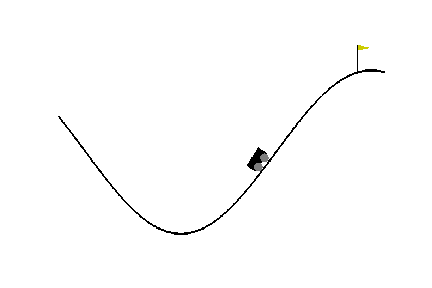
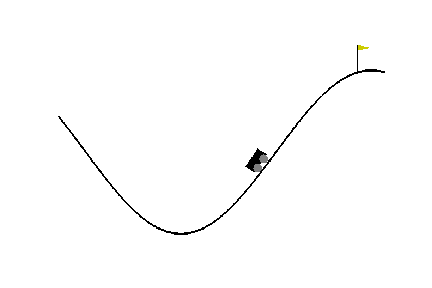
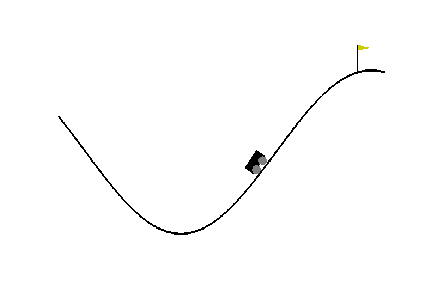
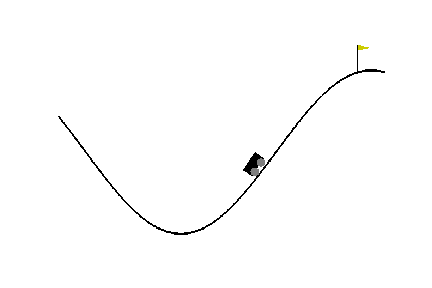
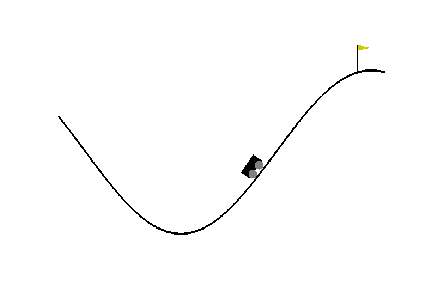
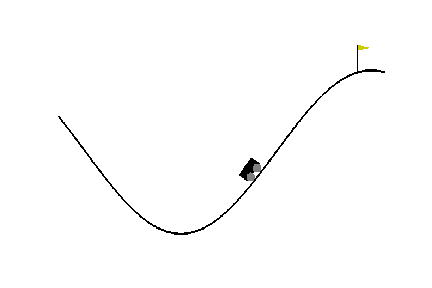
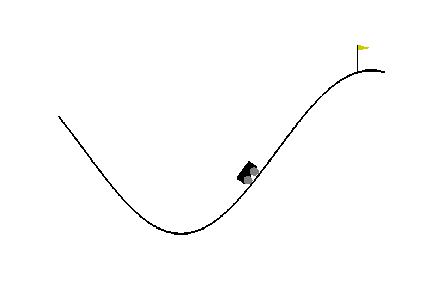
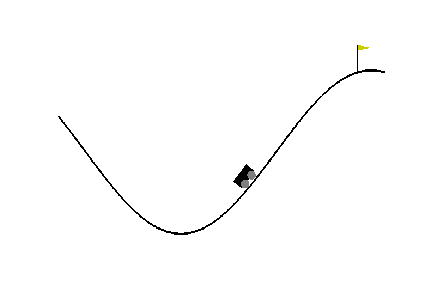
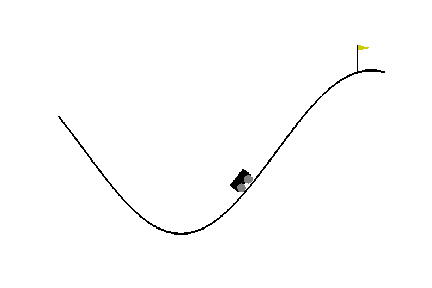
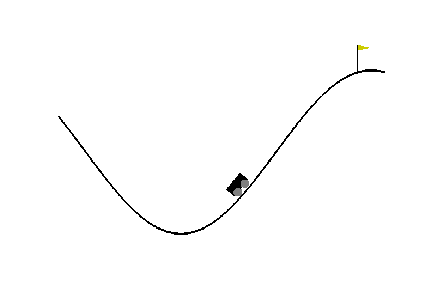
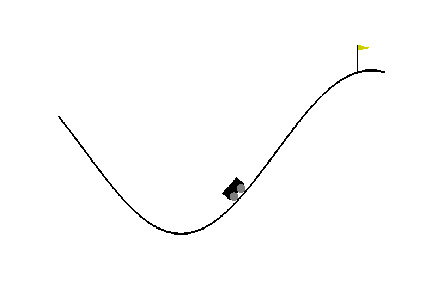
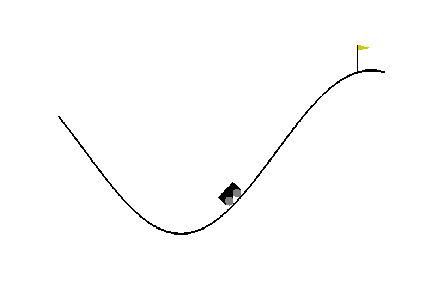
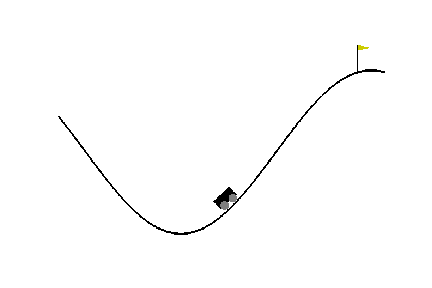
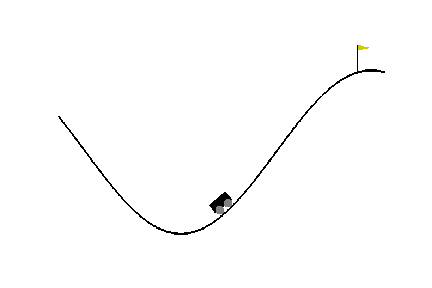
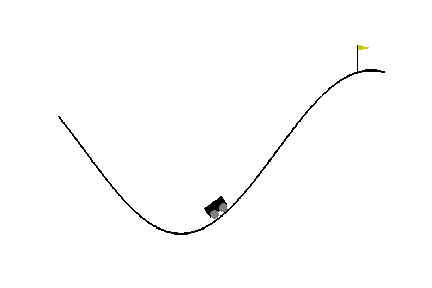
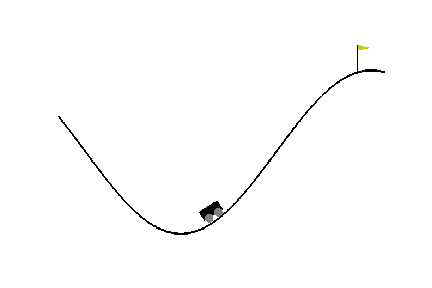
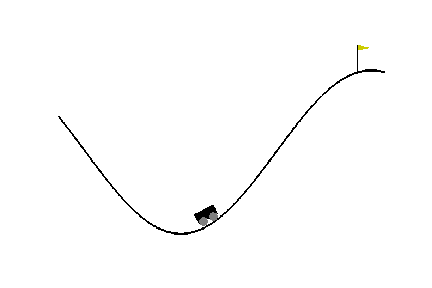
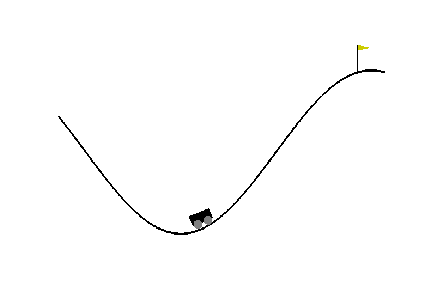
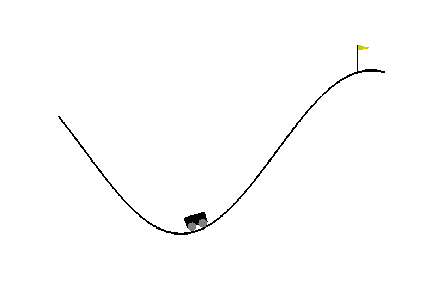
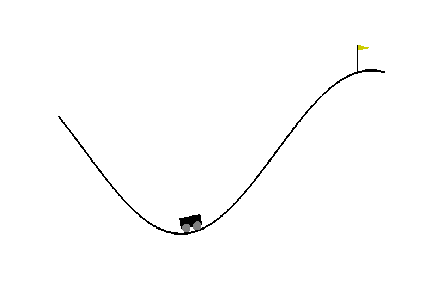
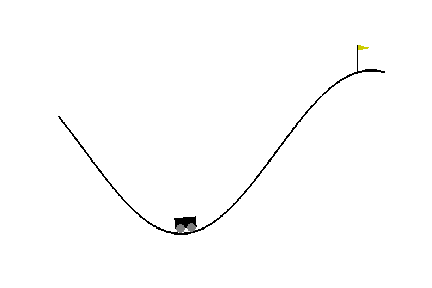
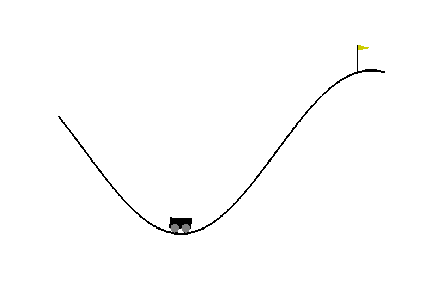
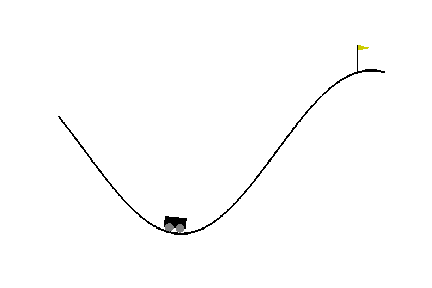
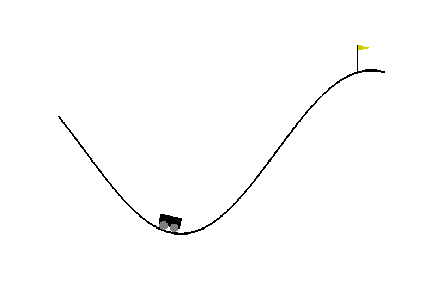
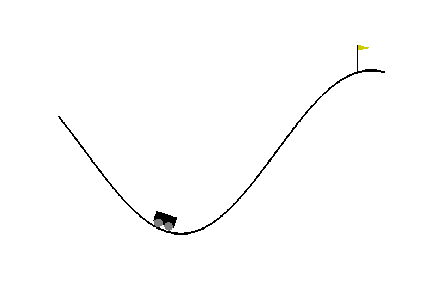
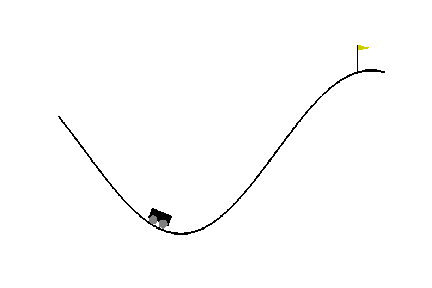
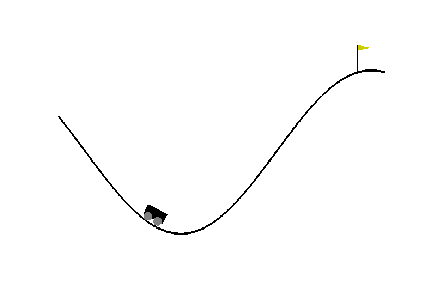
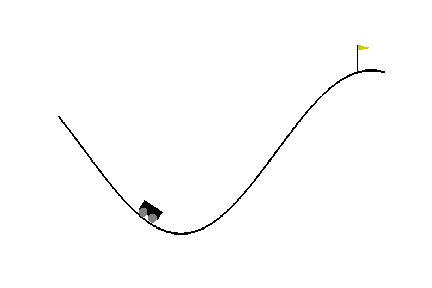
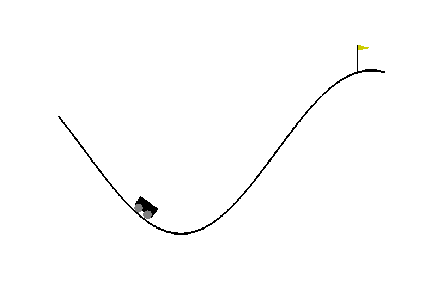
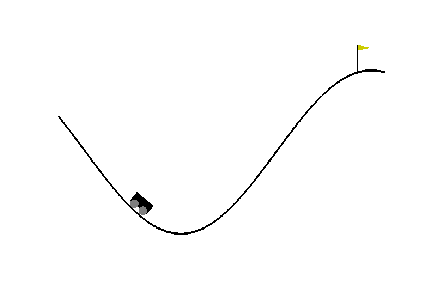
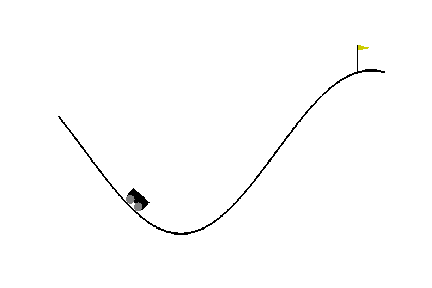
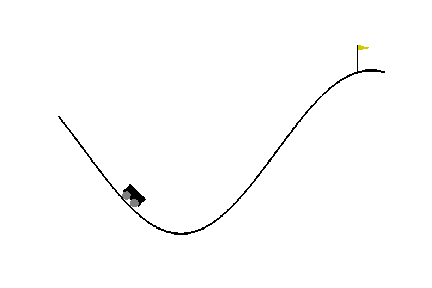
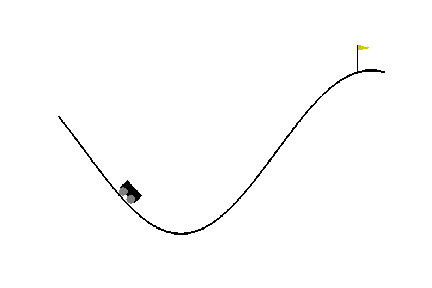
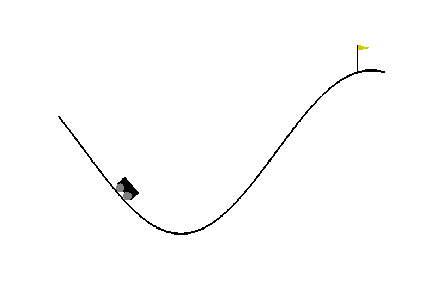
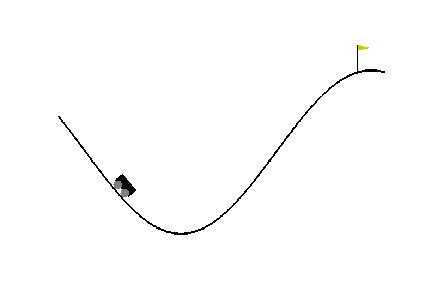
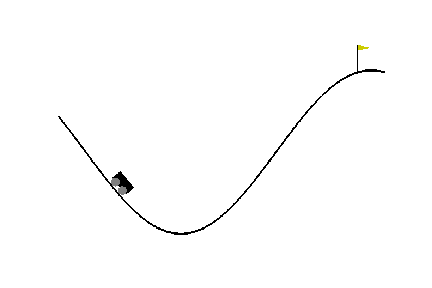
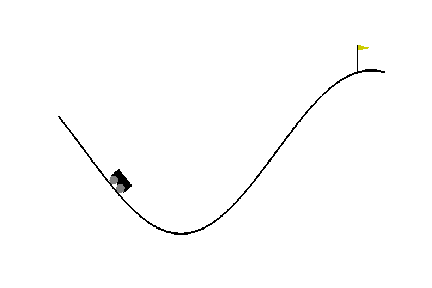
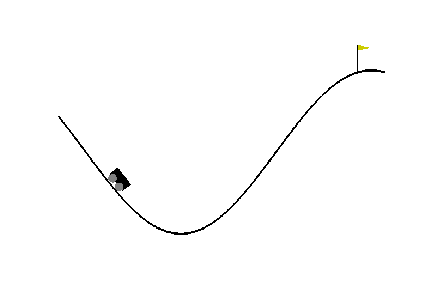
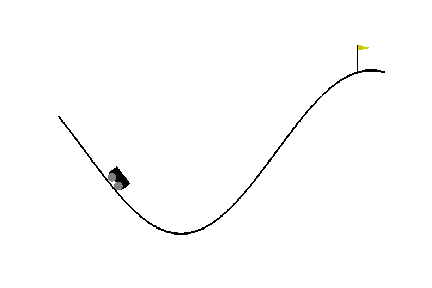
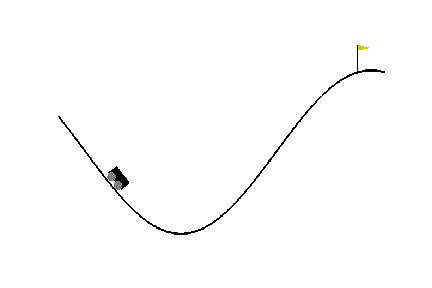
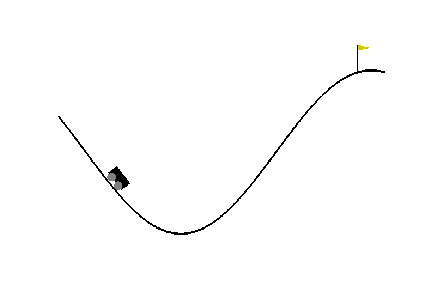
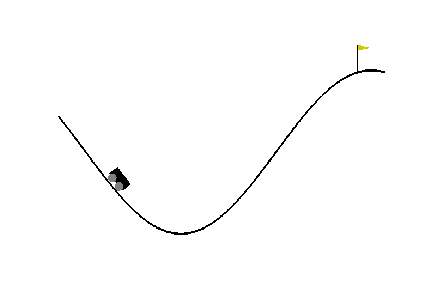
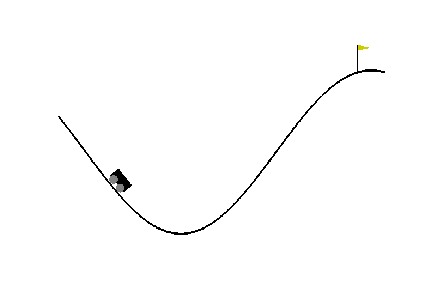
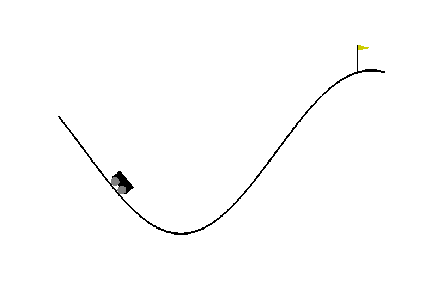
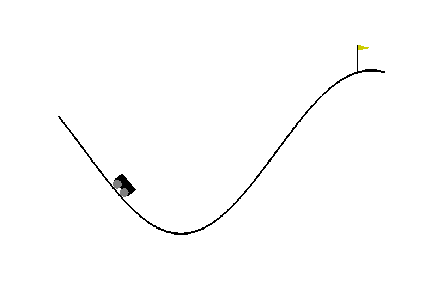
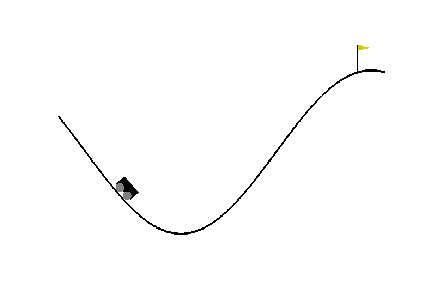
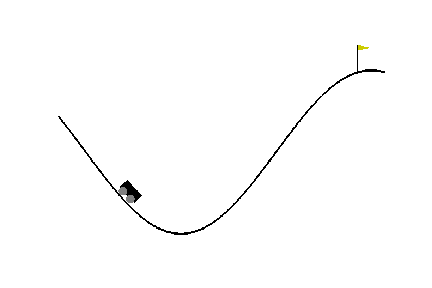
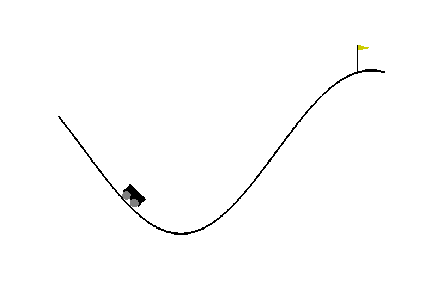
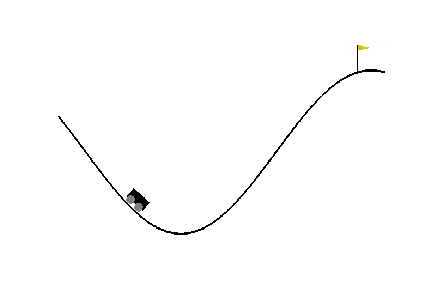
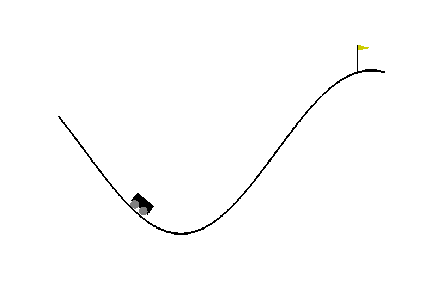
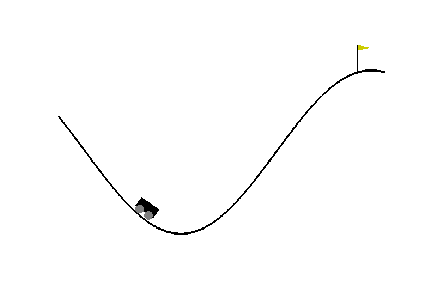
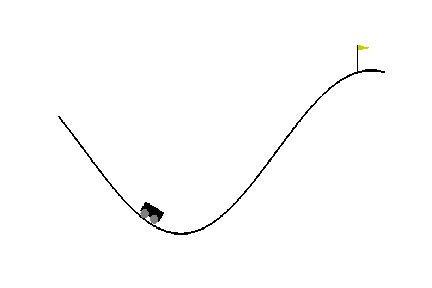
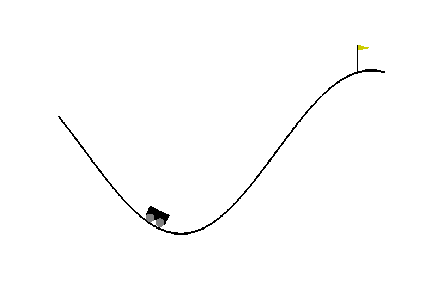
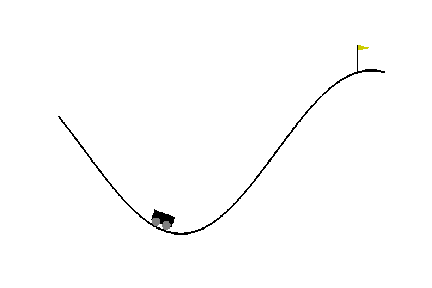
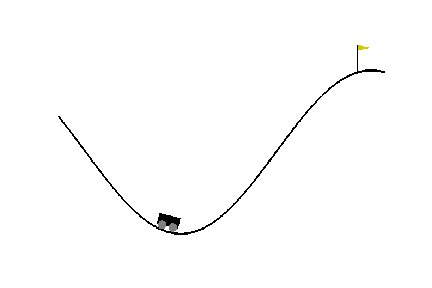
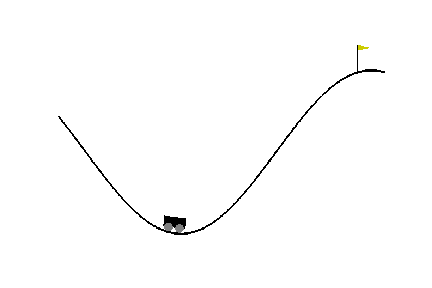
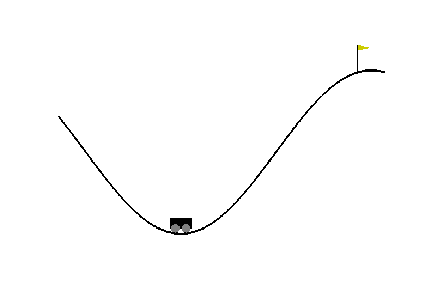
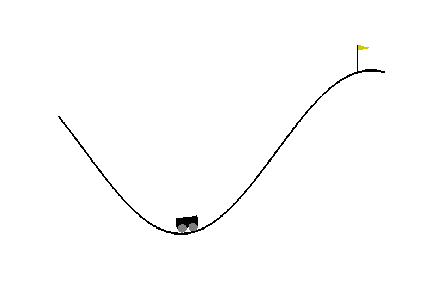
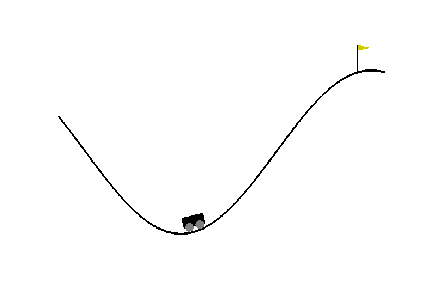
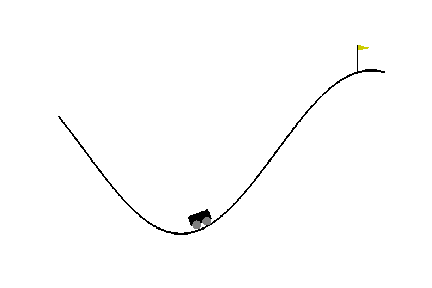
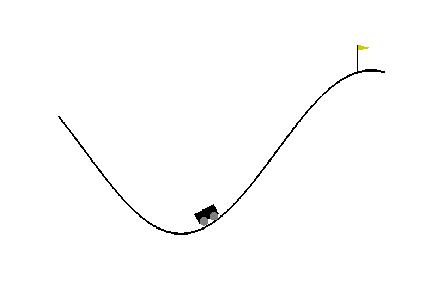
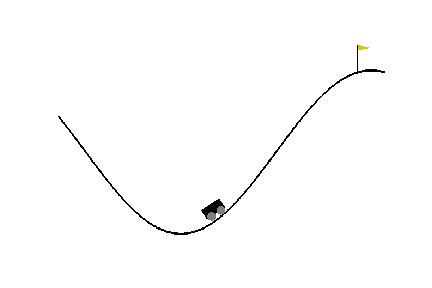
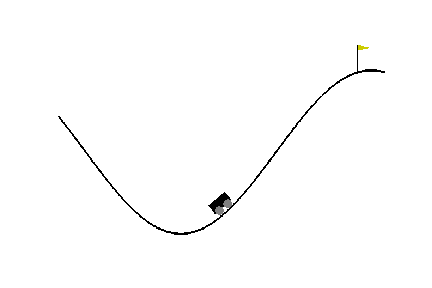
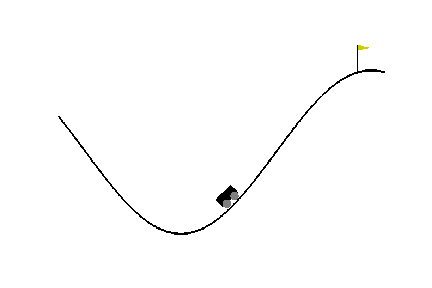
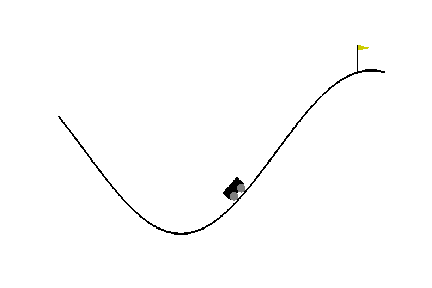
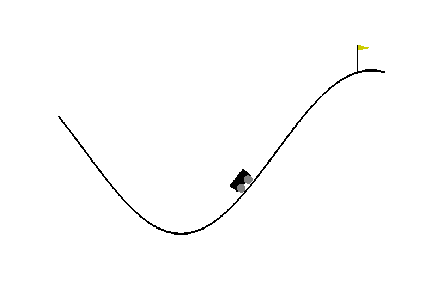
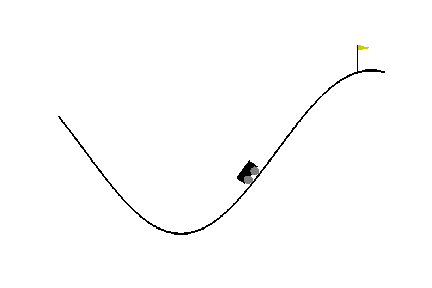
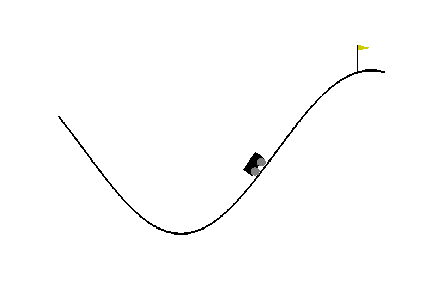
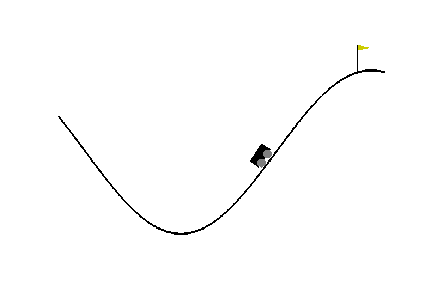
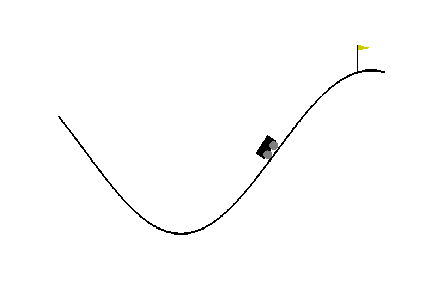
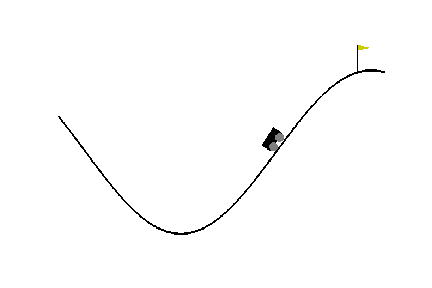
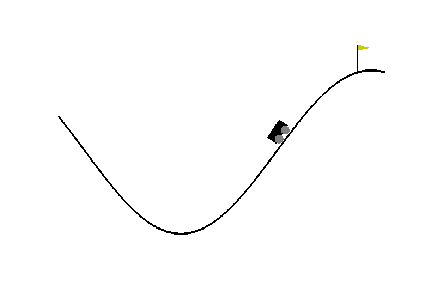
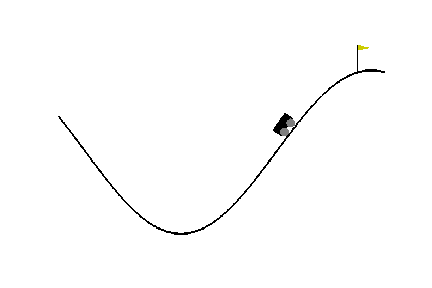
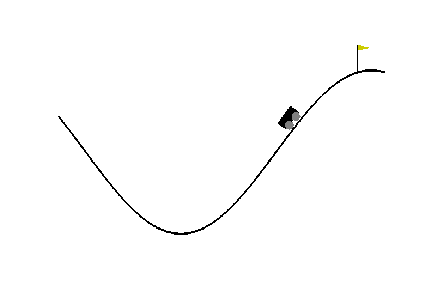
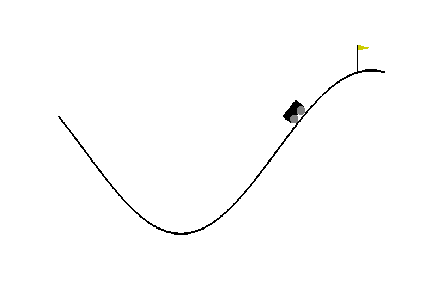
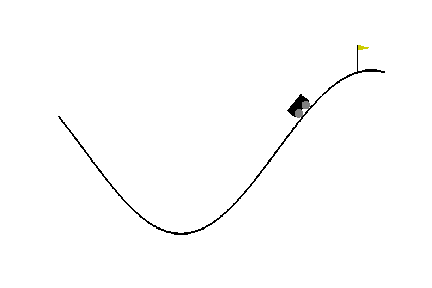
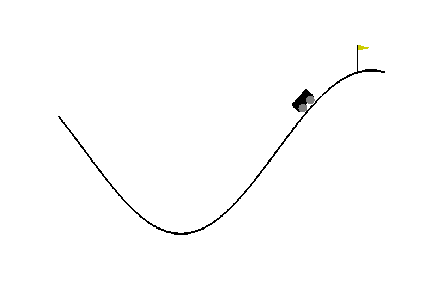
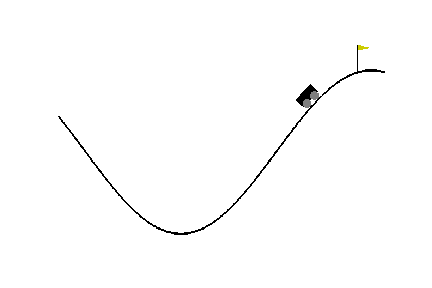
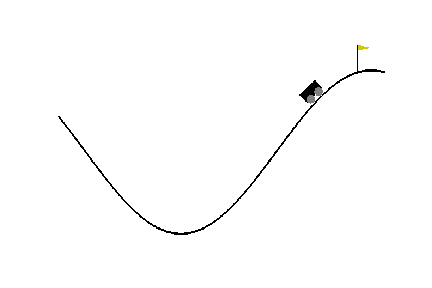
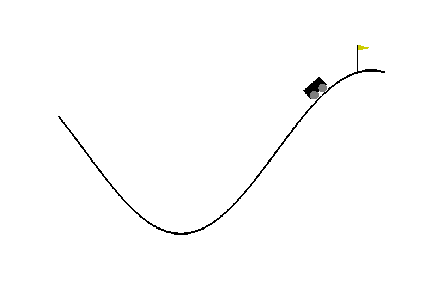
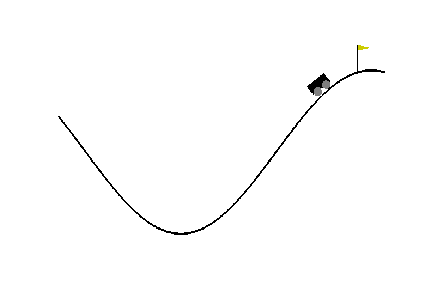
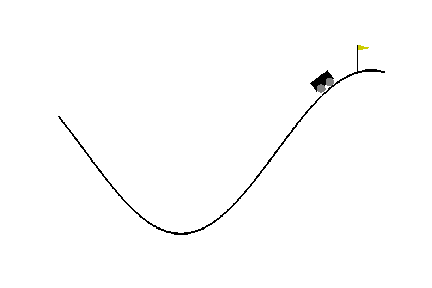
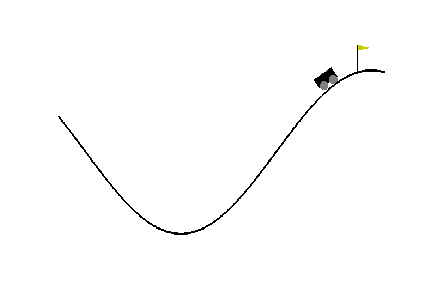
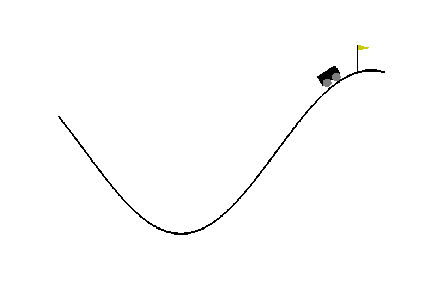
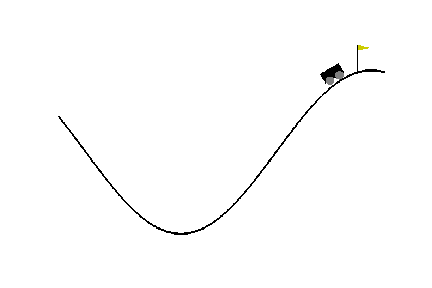
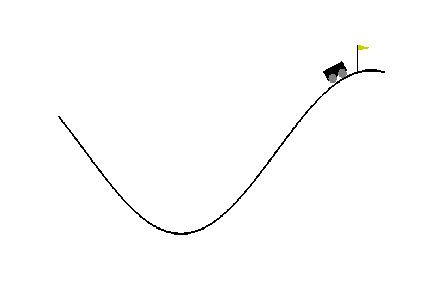
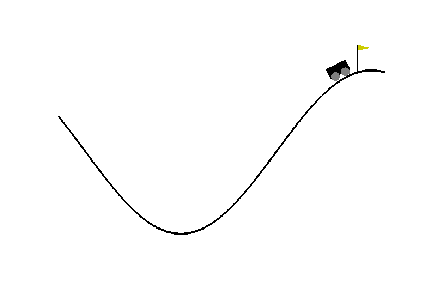
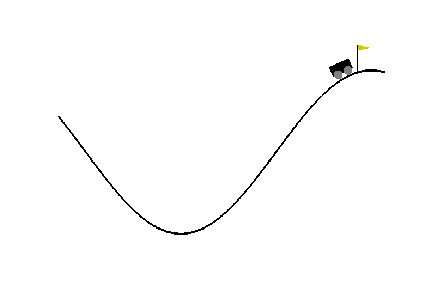
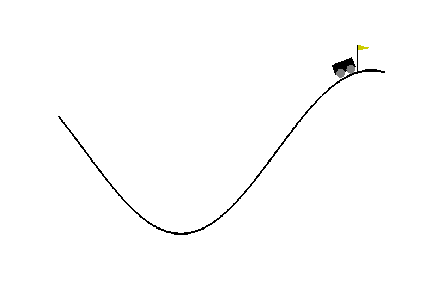
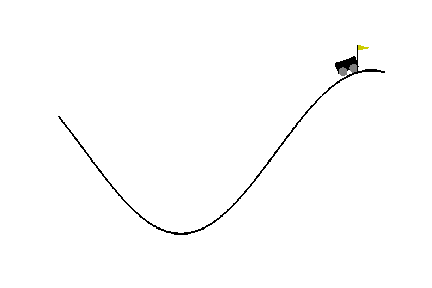
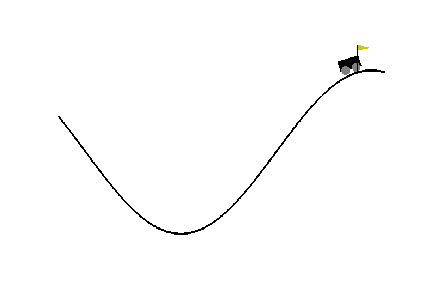
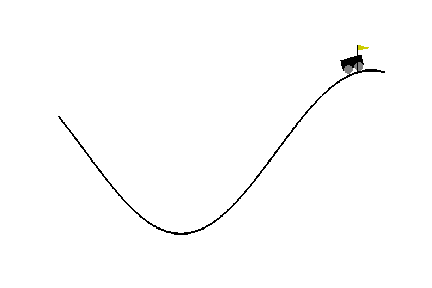
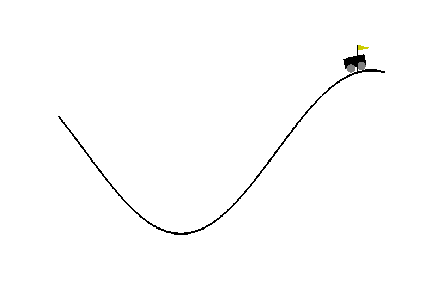

In [9]:
env = gym.make(envname)
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = policy.control(obs).reshape((1, -1)).astype(np.float32)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)